# Modeling

## Imports

In [148]:
# Imported Libraries 
import pandas as pd # pandas library 
import numpy as np # numpy library
import matplotlib.pyplot as plt # Import the pyplot (pythonplot) part of the matlotlib library
import seaborn as sns # seaborn library

from sklearn.model_selection import train_test_split # Train, Validation, Test Split
from sklearn.preprocessing import StandardScaler # Standard Scaling
from sklearn.linear_model import LogisticRegression # Logistic Regression Imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


#from mlxtend.plotting import plot_decision_regions # for visualising classification decision boundaries in 2D


## Helper Functions

High Correlation Pairs

In [35]:
def show_high_corr_pairs(corr_matrix, threshold=0.5):
    '''
    
    '''
    high_corr_pairs = corr_matrix[(corr_matrix.abs() >= 0.5) & (corr_matrix != 1.0)]
    high_corr_pairs = high_corr_pairs.dropna(how='all').dropna(axis=1, how='all')

    return high_corr_pairs

Plot Boundries of a Decision Tree

In [124]:
def PlotBoundaries(model, X, Y, dot_size=20, figsize=(10,7)) :
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1,X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, Z, alpha=0.4)

    #Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=dot_size, edgecolor='k')
    plt.show()

## Data Loading

In [2]:
## Data Loading
# Data loading for github only

CLN_DATA_PATH='../data/heart_attack_enc_m.csv'

try:
    heart_attack_enc_m = pd.read_csv(CLN_DATA_PATH, index_col= 0)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: The data file does not exist.")

Data loaded successfully.


In [23]:
heart_attack_enc_m.head()

PhysicalHealthDays  MentalHealthDays  SleepHours  HeightInMeters  \
0                 4.0               0.0         9.0            1.60   
1                 0.0               0.0         6.0            1.78   
2                 0.0               0.0         8.0            1.85   
3                 5.0               0.0         9.0            1.70   
4                 3.0              15.0         5.0            1.55   

   WeightInKilograms    BMI  LastCheckupTime_enc  Gender_enc  \
0              71.67  27.99                  0.0         0.0   
1              95.25  30.13                  0.0         1.0   
2             108.86  31.66                  0.0         1.0   
3              90.72  31.32                  0.0         0.0   
4              79.38  33.07                  0.0         0.0   

   GeneralHealth_enc  PhysicalActivities_enc  ...  \
0                3.0                     1.0  ...   
1                3.0                     1.0  ...   
2                3.0                     0.0  ...   
3                1.0                     1.0  ...   
4                2.0                     1.0  ...   

   BlindOrVisionDifficulty_enc  DifficultyWalking_enc  \
0                          0.0                    0.0   
1                          0.0                    0.0   
2                          1.0                    1.0   
3                          0.0                    1.0   
4                          0.0                    0.0   

   DifficultyDressingBathing_enc  DifficultyErrands_enc  ChestScan_enc  \
0                            0.0                    0.0            0.0   
1                            0.0                    0.0            0.0   
2                            0.0                    0.0            1.0   
3                            0.0                    0.0            0.0   
4                            0.0                    0.0            0.0   

   AlcoholDrinkers_enc  HIVTesting_enc  FluVaxLast12_enc  PneumoVaxEver_enc  \
0                  0.0             0.0               1.0                1.0   
1                  0.0             0.0               1.0                1.0   
2                  1.0             0.0               0.0                1.0   
3                  0.0             0.0               1.0                1.0   
4                  0.0             0.0               1.0                1.0   

   HighRiskLastYear_enc  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 36 columns]

In [24]:
heart_attack_enc_m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 246004 entries, 0 to 246012
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   PhysicalHealthDays             246004 non-null  float64
 1   MentalHealthDays               246004 non-null  float64
 2   SleepHours                     246004 non-null  float64
 3   HeightInMeters                 246004 non-null  float64
 4   WeightInKilograms              246004 non-null  float64
 5   BMI                            246004 non-null  float64
 6   LastCheckupTime_enc            246004 non-null  float64
 7   Gender_enc                     246004 non-null  float64
 8   GeneralHealth_enc              246004 non-null  float64
 9   PhysicalActivities_enc         246004 non-null  float64
 10  SmokerStatus_enc               246004 non-null  float64
 11  ECigaretteUsage_enc            246004 non-null  float64
 12  AgeCategory_enc                2460

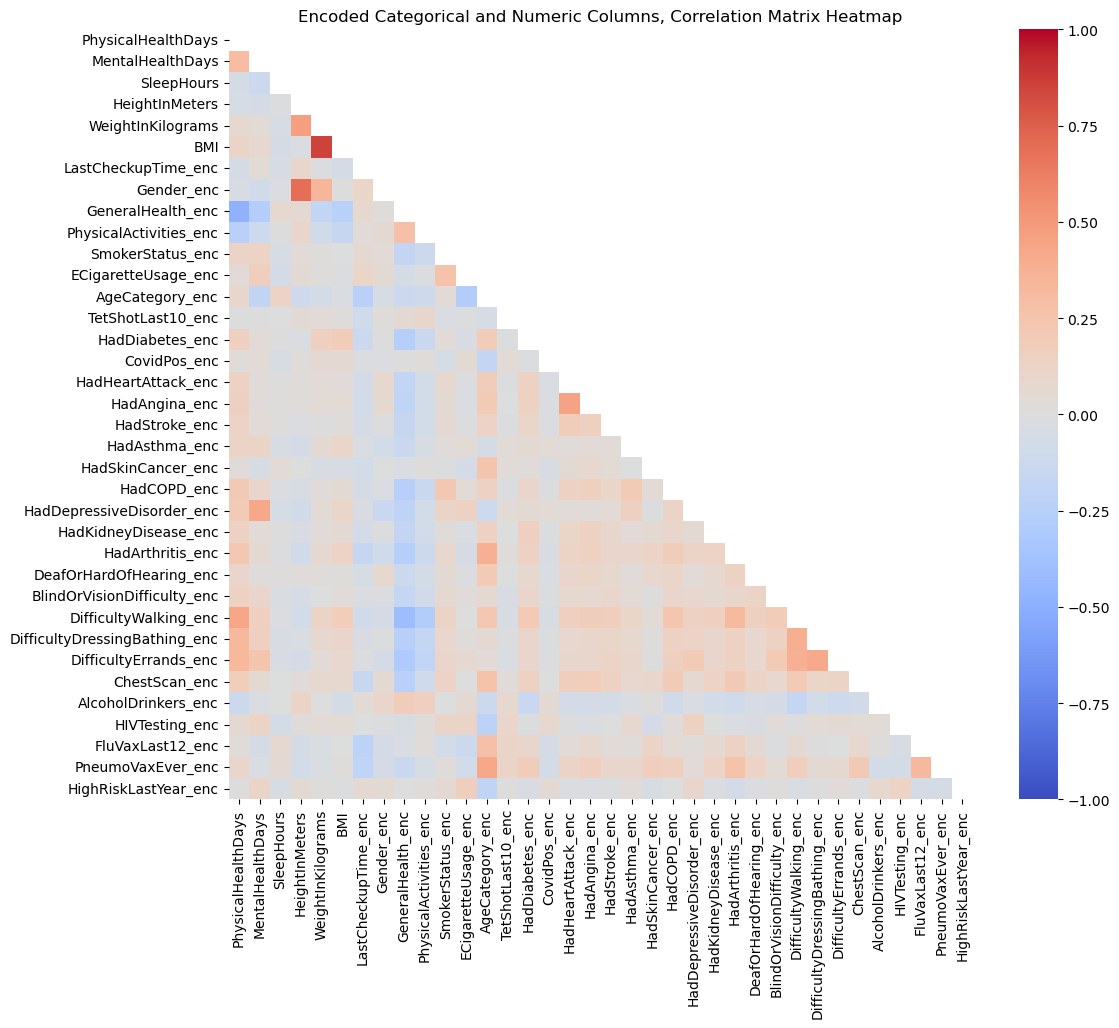

In [25]:
# Select only numerical columns
numeric_columns = heart_attack_enc_m

# Compute the correlation matrix
corr_matrix = numeric_columns.corr()

# Mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix,  cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, mask=mask)
plt.title('Encoded Categorical and Numeric Columns, Correlation Matrix Heatmap')
plt.show()

In [36]:
# Printing all the values of the correlation matrix that are above 0.05

high_corr_cols = show_high_corr_pairs(corr_matrix)

print(high_corr_cols)

                   HeightInMeters  WeightInKilograms       BMI  Gender_enc
HeightInMeters                NaN                NaN       NaN    0.693434
WeightInKilograms             NaN                NaN  0.859296         NaN
BMI                           NaN           0.859296       NaN         NaN
Gender_enc               0.693434                NaN       NaN         NaN


## Logistic Regression

In [3]:
#Split into X and y
X = heart_attack_enc_m.drop(columns='HadHeartAttack_enc', axis=1)
y = heart_attack_enc_m['HadHeartAttack_enc']


In [4]:
# Spliting into Remainder and Test (80% : 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12, stratify= y)

In [5]:
# Splitting the remainder in two, train and validation sets (Of the 80% = 80% : 20%)
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train, y_train, test_size = 0.2,random_state=12, stratify= y_train) # Always use the same random states.

### Model - Logistic Regression

#### Logistic Regression Model 1 (logreg_model1)

In [125]:
# Instantiate Model
logreg_model1 = LogisticRegression(max_iter=10000)

# Fit
logreg_model1.fit(X_train_subset, y_train_subset)

LogisticRegression(max_iter=10000)

In [136]:
PlotBoundaries(logreg_model1, X, y)

InvalidIndexError: (slice(None, None, None), 0)

In [68]:
# Creating the train and test predictions

y_train_pred = logreg_model1.predict(X_train_subset)
y_val_pred = logreg_model1.predict(X_val)
y_test_pred = logreg_model1.predict(X_test)


In [69]:
print(f'Logistic Regression Train Score: {logreg_model1.score(X_train, y_train).round(2)}\n')
print(f'Logistic Regression Test Score:{logreg_model1.score(X_test, y_test).round(2)}')

Logistic Regression Train Score: 0.95

Logistic Regression Test Score:0.95


In [70]:
# Classification Report (accuracy, precision, recall, f1)
report_val = classification_report(y_val, y_val_pred)
print(report_val)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     37211
         1.0       0.55      0.25      0.34      2150

    accuracy                           0.95     39361
   macro avg       0.75      0.62      0.66     39361
weighted avg       0.94      0.95      0.94     39361



In [71]:
# Classification Report (accuracy, precision, recall, f1)
report_test = classification_report(y_test, y_test_pred)
print(report_test)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     46514
         1.0       0.55      0.24      0.34      2687

    accuracy                           0.95     49201
   macro avg       0.76      0.62      0.66     49201
weighted avg       0.94      0.95      0.94     49201



Confusion Matrix - Train:
[[147182   1662]
 [  6464   2134]]


<Figure size 800x600 with 0 Axes>

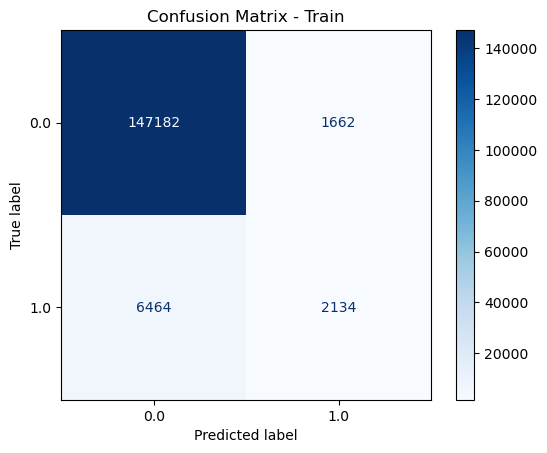

In [73]:
# Generate confusion matrix
cm_lr_train = confusion_matrix(y_train_subset, y_train_pred)
print("Confusion Matrix - Train:")
print(cm_lr_train)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_train, display_labels=logreg_model1.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Train')
plt.show()


Confusion Matrix - Train:
[[45991   523]
 [ 2035   652]]


<Figure size 800x600 with 0 Axes>

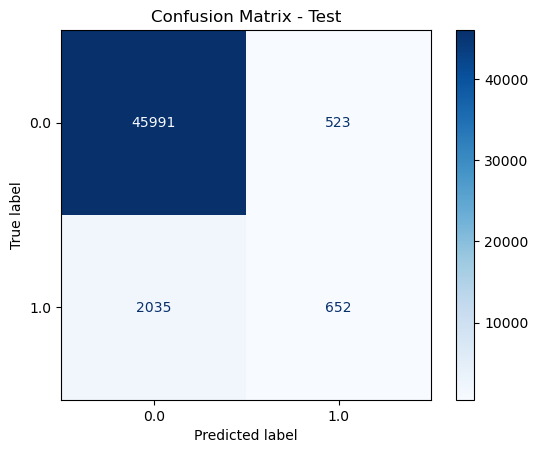

In [75]:
# Generate confusion matrix
cm_lr_train = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix - Train:")
print(cm_lr_train)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_train, display_labels=logreg_model1.classes_)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test')
plt.show()

In [76]:
logreg_coeff = pd.DataFrame(logreg_model1.coef_, columns= X_train.columns, index= ["Coeff"]).T
logreg_coeff.sort_values(by= "Coeff", ascending= False)

Coeff
HadAngina_enc                  2.432695
HadStroke_enc                  0.879605
Gender_enc                     0.686212
ChestScan_enc                  0.575729
HadDiabetes_enc                0.328889
SmokerStatus_enc               0.198884
AgeCategory_enc                0.179019
BlindOrVisionDifficulty_enc    0.138785
DifficultyWalking_enc          0.094504
HIVTesting_enc                 0.092302
DifficultyErrands_enc          0.088228
HadCOPD_enc                    0.067619
HadDepressiveDisorder_enc      0.064190
HighRiskLastYear_enc           0.062838
PneumoVaxEver_enc              0.056274
HeightInMeters                 0.049357
HadArthritis_enc               0.037998
HadAsthma_enc                  0.029926
DeafOrHardOfHearing_enc        0.028031
ECigaretteUsage_enc            0.024101
HadKidneyDisease_enc           0.021320
BMI                            0.011930
CovidPos_enc                   0.003542
MentalHealthDays               0.002027
PhysicalHealthDays            -0.002131
WeightInKilograms             -0.004126
SleepHours                    -0.033146
TetShotLast10_enc             -0.036487
PhysicalActivities_enc        -0.036973
DifficultyDressingBathing_enc -0.075511
HadSkinCancer_enc             -0.092580
LastCheckupTime_enc           -0.126283
FluVaxLast12_enc              -0.186040
AlcoholDrinkers_enc           -0.216630
GeneralHealth_enc             -0.288395

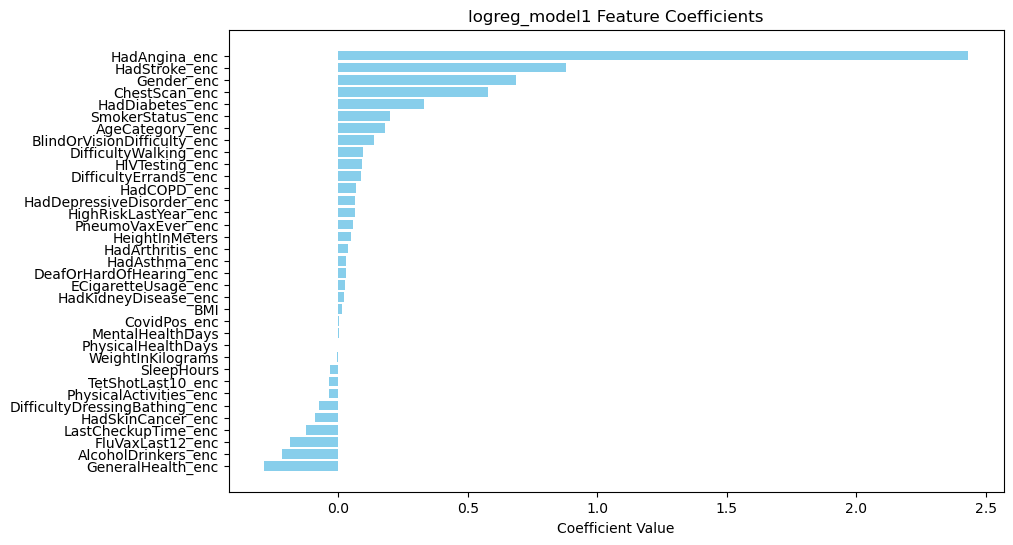

In [83]:
# Combine coefficients and feature names
coef_names = list(zip(coefficients, feature_names))

# Sort coefficients and feature names in descending order
coef_names.sort(reverse=False)

# Separate sorted coefficients and feature names
sorted_coefficients = [coef for coef, name in coef_names]
sorted_feature_names = [name for coef, name in coef_names]

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('logreg_model1 Feature Coefficients')
plt.show()

#### Logistic Regression Model 2

Scaling - Logistic Regression Model 2

In [84]:
# Pre-processing - scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [97]:
validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000, 100000000, 1000000000])

for c in C_range:
    logreg_model2 = LogisticRegression(max_iter=10000, C = c, random_state= 12, n_jobs= 4)
    logreg_model2.fit(X_train_scaled,y_train)
    
    # train on traning set
    train_scores.append(logreg_model2.score(X_train_scaled,y_train))
    # score on validation set
    validation_scores.append(logreg_model2.score(X_val_scaled,y_val))

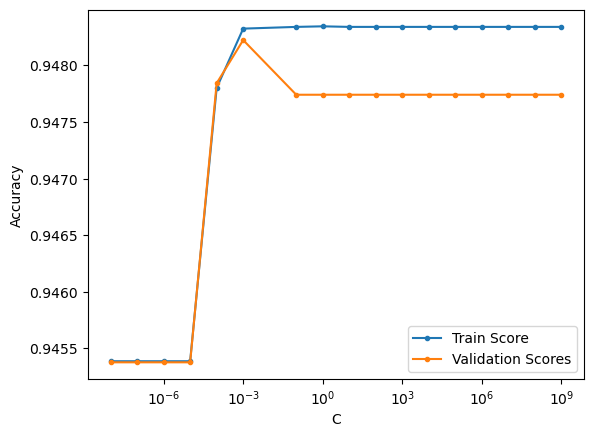

In [98]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log') # logarithmic scale needed on this example
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

**Optimised logreg_model2**

In [100]:
# Optimized C value
opt_C = .001 

# Instantiate Model
opt_logreg_model2 = LogisticRegression(max_iter=10000, C= opt_C, random_state=12)

# Fit
opt_logreg_model2.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, max_iter=10000, random_state=12)

In [101]:
# Creating the train and test predictions

y_train_pred = opt_logreg_model2.predict(X_train_scaled)
y_val_pred = opt_logreg_model2.predict(X_val_scaled)
y_test_pred = opt_logreg_model2.predict(X_test_scaled)

In [102]:
print(f'Optimized Logistic Regression Train Score: {logreg_model2.score(X_train_scaled, y_train).round(2)}\n')
print(f'Optimized Logistic Regression Validation Score: {logreg_model2.score(X_val_scaled, y_val).round(2)}\n')
print(f'Optimized Logistic Regression Test Score:{logreg_model2.score(X_test_scaled, y_test).round(2)}')

Optimized Logistic Regression Train Score: 0.95

Optimized Logistic Regression Validation Score: 0.95

Optimized Logistic Regression Test Score:0.95


In [103]:
# Classification Report (accuracy, precision, recall, f1)
report_train_opt = classification_report(y_train, y_train_pred)
print(report_train_opt)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    186055
         1.0       0.57      0.23      0.33     10748

    accuracy                           0.95    196803
   macro avg       0.76      0.61      0.65    196803
weighted avg       0.94      0.95      0.94    196803



In [104]:
# Classification Report (accuracy, precision, recall, f1)
report_test = classification_report(y_test, y_test_pred)
print(report_test)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     46514
         1.0       0.56      0.22      0.32      2687

    accuracy                           0.95     49201
   macro avg       0.76      0.61      0.65     49201
weighted avg       0.93      0.95      0.94     49201



Confusion Matrix - Train:
[[184175   1880]
 [  8290   2458]]


<Figure size 800x600 with 0 Axes>

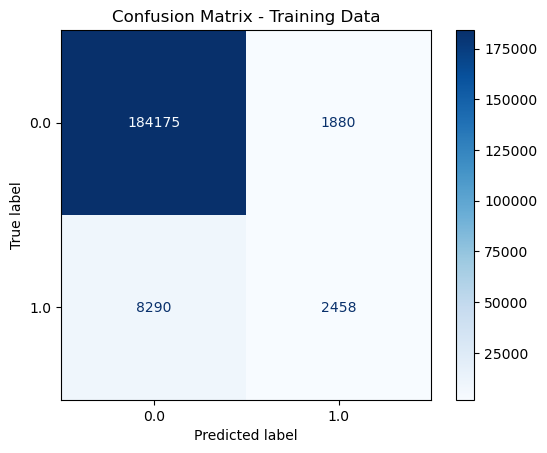

In [114]:
# Confusion Matrix Train Variable
cm_opt_lr_train = confusion_matrix(y_train, y_train_pred)

# Prints Train Confusion Matrix
print("Confusion Matrix - Train:")
print(cm_opt_lr_train)

# Display confusion matrix for training data
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_opt_lr_train, display_labels=opt_logreg_model2.classes_)
plt.figure(figsize=(8, 6))
disp_train.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Training Data')
plt.show()

Confusion Matrix - Train:
[[46040   474]
 [ 2090   597]]


<Figure size 800x600 with 0 Axes>

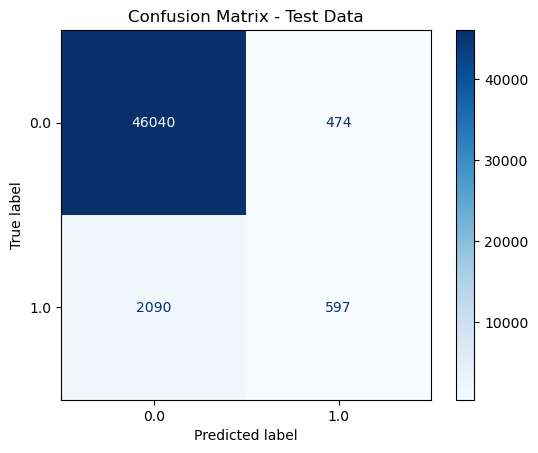

In [115]:
# Confusion Matrix Test Variable
cm_opt_lr_test = confusion_matrix(y_test, y_test_pred)

# Prints Test Confusion Matrix
print("Confusion Matrix - Train:")
print(cm_opt_lr_test)

# Test Confusion Matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_opt_lr_test, display_labels=opt_logreg_model2.classes_)
plt.figure(figsize=(8, 6))
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.show()

In [107]:
opt_logreg_coeff2 = pd.DataFrame(opt_logreg_model2.coef_, columns= X_train.columns, index= ["Coeff"]).T
opt_logreg_coeff2.sort_values(by= "Coeff", ascending= False)

Coeff
HadAngina_enc                  0.571664
AgeCategory_enc                0.457068
Gender_enc                     0.290550
ChestScan_enc                  0.259435
HadStroke_enc                  0.170823
SmokerStatus_enc               0.157425
HadDiabetes_enc                0.116574
PneumoVaxEver_enc              0.049604
DifficultyWalking_enc          0.039285
BlindOrVisionDifficulty_enc    0.031337
HadCOPD_enc                    0.029802
HadArthritis_enc               0.028532
DifficultyErrands_enc          0.022470
DeafOrHardOfHearing_enc        0.021078
HIVTesting_enc                 0.016874
HadKidneyDisease_enc           0.014540
MentalHealthDays               0.005214
BMI                            0.003805
HadDepressiveDisorder_enc      0.003187
PhysicalHealthDays             0.003108
HadAsthma_enc                  0.000814
ECigaretteUsage_enc           -0.003526
HighRiskLastYear_enc          -0.004225
CovidPos_enc                  -0.008651
WeightInKilograms             -0.010530
HeightInMeters                -0.012704
DifficultyDressingBathing_enc -0.015277
HadSkinCancer_enc             -0.016614
PhysicalActivities_enc        -0.024071
TetShotLast10_enc             -0.025142
SleepHours                    -0.035110
FluVaxLast12_enc              -0.058981
AlcoholDrinkers_enc           -0.094732
LastCheckupTime_enc           -0.098304
GeneralHealth_enc             -0.257144

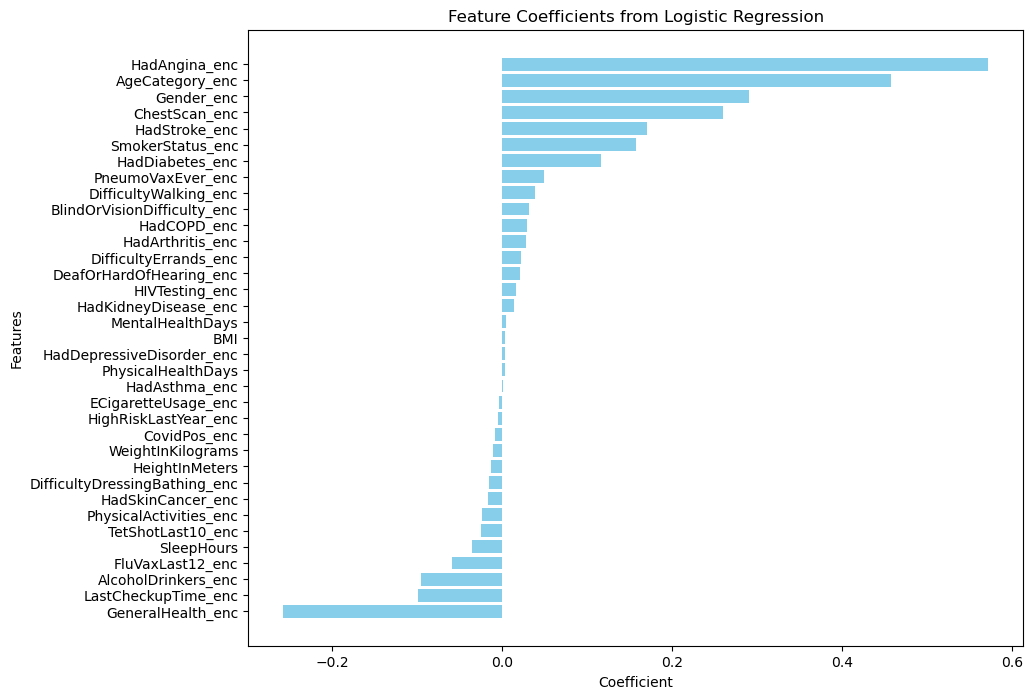

In [109]:
# Sort the DataFrame by coefficient values
opt_logreg_coeff2_sorted = opt_logreg_coeff2.sort_values(by="Coeff", ascending=False)

# Plot coefficients
plt.figure(figsize=(10, 8))
plt.barh(opt_logreg_coeff2_sorted.index, opt_logreg_coeff2_sorted['Coeff'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Features')
plt.title('Feature Coefficients from Logistic Regression')
plt.gca().invert_yaxis()  # To display the highest coefficients on top
plt.show()

Pipeline Gridsearch - logreg_model3

In [116]:
# Making a pipeline esimator list 
lr_estimators = [('scaler', StandardScaler()),
                    ('lr', LogisticRegression(max_iter=1000, random_state=12))
]

pipe = Pipeline(lr_estimators)
print(pipe) # Checking the pipe has been correctly made

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=1000, random_state=12))])


In [117]:
# Logistic Regression3 - Defining V1 grid search

C = ([.00000001, .0000001, .000001, .00001, .0001, .001, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000])

penalty = ['l1', 'l2']

solver = ['saga', 'liblinear']

params = [dict(
    lr = [LogisticRegression()],
    lr__C = C,
    lr__penalty = penalty,
    lr__solver = solver
)]
display(params)

[{'lr': [LogisticRegression()],
  'lr__C': [1e-08,
   1e-07,
   1e-06,
   1e-05,
   0.0001,
   0.001,
   0.1,
   1,
   10,
   100,
   1000,
   10000,
   100000,
   1000000,
   10000000,
   100000000,
   1000000000],
  'lr__penalty': ['l1', 'l2'],
  'lr__solver': ['saga', 'liblinear']}]

In [118]:
# Logistic Regression Grid Search V1
grid_search_model_V1 = GridSearchCV(estimator= pipe, param_grid=params,cv=5, n_jobs= 4, verbose= 2)
grid_search_model_V1.fit(X_train, y_train)

Fitting 5 folds for each of 68 candidates, totalling 340 fits
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.3s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.3s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.3s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.3s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.3s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=liblinear; total time=   0.3s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=liblinear; total time=   0.3s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=liblinear; total time=   0.3s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=liblinear; total time=   0.2s
[CV] END lr=LogisticRegress

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END lr=LogisticRegression(), lr__C=1000000000, lr__penalty=l1, lr__solver=liblinear; total time=   3.3s
[CV] END lr=LogisticRegression(), lr__C=1000000000, lr__penalty=l2, lr__solver=saga; total time=   1.7s
[CV] END lr=LogisticRegression(), lr__C=1000000000, lr__penalty=l2, lr__solver=saga; total time=   1.8s
[CV] END lr=LogisticRegression(), lr__C=1000000000, lr__penalty=l2, lr__solver=saga; total time=   1.6s
[CV] END lr=LogisticRegression(), lr__C=1000000000, lr__penalty=l2, lr__solver=liblinear; total time=   0.6s
[CV] END lr=LogisticRegression(), lr__C=1000000000, lr__penalty=l2, lr__solver=liblinear; total time=   0.7s
[CV] END lr=LogisticRegression(), lr__C=1000000000, lr__penalty=l2, lr__solver=saga; total time=   1.9s
[CV] END lr=LogisticRegression(), lr__C=1000000000, lr__penalty=l2, lr__solver=liblinear; total time=   0.7s
[CV] END lr=LogisticRegression(), lr__C=1000000000, lr__penalty=l2, lr__solver=saga; total time=   2.2s
[CV] END lr=LogisticRegression(), lr__C=1000

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=12))]),
             n_jobs=4,
             param_grid=[{'lr': [LogisticRegression(C=0.001,
                                                    solver='liblinear')],
                          'lr__C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                    0.1, 1, 10, 100, 1000, 10000, 100000,
                                    1000000, 10000000, 100000000, 1000000000],
                          'lr__penalty': ['l1', 'l2'],
                          'lr__solver': ['saga', 'liblinear']}],
             verbose=2)

In [119]:
# Extracting the essential information 

# Result of the grid search optimisation process - best hyperparameter and best model
print('Best Score:', grid_search_model_V1.best_score_); 
print('Best C Value:', grid_search_model_V1.best_estimator_.get_params()['lr__C'])
print('Best lr Model:', grid_search_model_V1.best_estimator_.get_params()['lr'])
print('Best penalty:', grid_search_model_V1.best_estimator_.get_params()['lr__penalty'])
print('Best solver:', grid_search_model_V1.best_estimator_.get_params()['lr__solver'])


Best Score: 0.948334122619001
Best C Value: 0.001
Best lr Model: LogisticRegression(C=0.001, solver='liblinear')
Best penalty: l2
Best solver: liblinear


In [151]:
best_lr_pipe_V1 = grid_search_model_V1.best_estimator_

In [121]:
best_lr_pipe_V1.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [122]:
# Making the train and test predictions for the pipeed decision tree model
y_train_blrpipe_pred = best_lr_pipe_V1.predict(X_train)
y_test_blrpipe_pred = best_lr_pipe_V1.predict(X_test)

In [123]:
# Obtaining the best score on the train and test data for the best pipe model
print(f'Score on train: {best_lr_pipe_V1.score(X_train, y_train)}')
print(f'Score on test: {best_lr_pipe_V1.score(X_test, y_test)}')

Score on train: 0.948298552359466
Score on test: 0.9479888620149997


Train Metrics

In [124]:
# Classification Report (accuracy, precision, recall, f1)
report_blrpipe_train = classification_report(y_train, y_train_blrpipe_pred)
print(report_blrpipe_train)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    186055
         1.0       0.57      0.23      0.33     10748

    accuracy                           0.95    196803
   macro avg       0.76      0.61      0.65    196803
weighted avg       0.94      0.95      0.94    196803



[[184144   1911]
 [  8264   2484]]


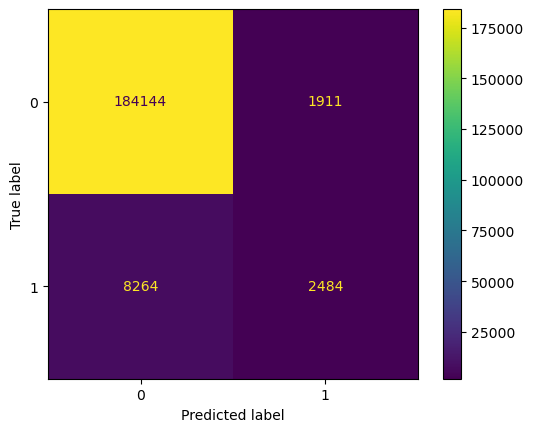

In [125]:
# Confusion Matrix (table + plot)
cm_blrpipe_train = confusion_matrix(y_train, y_train_blrpipe_pred)
print(cm_blrpipe_train)
ConfusionMatrixDisplay(confusion_matrix=cm_blrpipe_train).plot();

In [127]:
# # ROC Curve
# RocCurveDisplay(roc_auc=best_lr_pipe, X_test, y_test);

Test Metrics

In [128]:
# Obtaining the best score from the V1 model
grid_search_model_V1.best_score_

0.948334122619001

In [129]:
# Classification Report (accuracy, precision, recall, f1)
report_blrpipe_test = classification_report(y_test, y_test_blrpipe_pred)
print(report_blrpipe_test)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     46514
         1.0       0.56      0.22      0.32      2687

    accuracy                           0.95     49201
   macro avg       0.76      0.61      0.65     49201
weighted avg       0.93      0.95      0.94     49201



[[46042   472]
 [ 2087   600]]


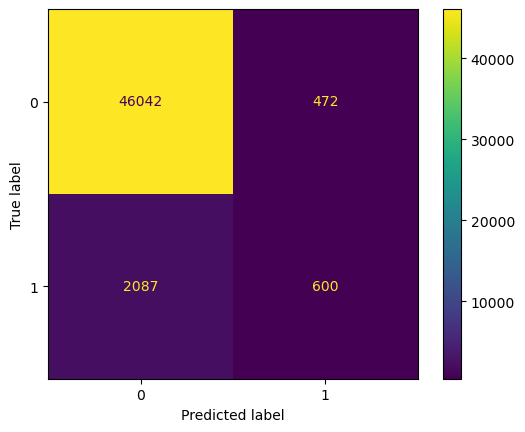

In [130]:
# Confusion Matrix (table + plot)
cm_blrpipe_test = confusion_matrix(y_test, y_test_blrpipe_pred)
print(cm_blrpipe_test)
ConfusionMatrixDisplay(confusion_matrix=cm_blrpipe_test).plot();

In [131]:
print(best_lr_pipe_V1.named_steps)

{'scaler': StandardScaler(), 'lr': LogisticRegression(C=0.001, solver='liblinear')}


                                  Coeff
HadAngina_enc                  0.520527
AgeCategory_enc                0.296907
Gender_enc                     0.221744
ChestScan_enc                  0.178080
HadStroke_enc                  0.151315
SmokerStatus_enc               0.109685
HadDiabetes_enc                0.095197
DifficultyWalking_enc          0.037202
HadCOPD_enc                    0.032197
PneumoVaxEver_enc              0.031883
BlindOrVisionDifficulty_enc    0.025094
DeafOrHardOfHearing_enc        0.020305
DifficultyErrands_enc          0.018635
HadKidneyDisease_enc           0.015840
HIVTesting_enc                 0.011388
HadArthritis_enc               0.010507
PhysicalHealthDays             0.008064
MentalHealthDays               0.003266
HadDepressiveDisorder_enc     -0.000538
HighRiskLastYear_enc          -0.001123
ECigaretteUsage_enc           -0.001740
HadAsthma_enc                 -0.001765
BMI                           -0.003814
CovidPos_enc                  -0.004282


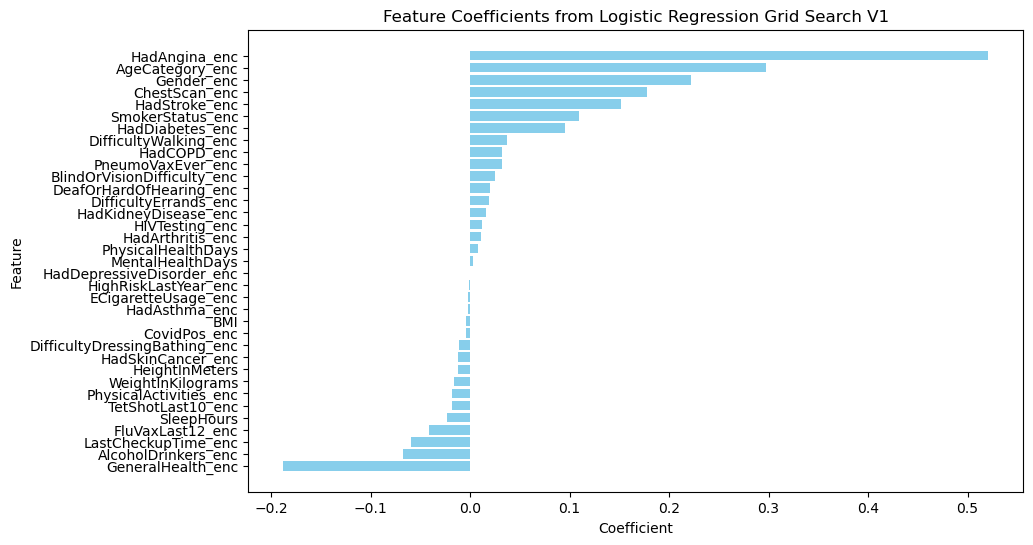

In [152]:
# Extract the logistic regression model from the pipeline
best_lr_logreg_model3 = best_lr_pipe_V1.named_steps['lr']

# Get the coefficients
coeff = best_lr_logreg_model3.coef_[0]

# Create a DataFrame for the coefficients
logreg_coeff3 = pd.DataFrame(coeff, index=X_train.columns, columns=['Coeff'])

# Sort the DataFrame by coefficient values
logreg_coeff3_sorted = logreg_coeff3.sort_values(by='Coeff', ascending=False)
print(logreg_coeff3_sorted)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(logreg_coeff3_sorted.index, logreg_coeff3_sorted['Coeff'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients from Logistic Regression Grid Search V1')
plt.gca().invert_yaxis()  # To display the highest coefficients on top
plt.show()


Pipeline Gridsearch - logreg_model4 (l1)

In [133]:
# Making a pipeline esimator list 
lr_estimators = [('scaler', StandardScaler()),
                    ('lr', LogisticRegression(max_iter=1000, random_state=12))
]

pipe = Pipeline(lr_estimators)
print(pipe) # Checking the pipe has been correctly made

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=1000, random_state=12))])


In [134]:
# Defining V3 grid search

C = ([.00000001, .0000001, .000001, .00001, .0001, .001, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000])

penalty = ['l1']

solver = ['saga', 'liblinear']

params = [dict(
    lr = [LogisticRegression()],
    lr__C = C,
    lr__penalty = penalty,
    lr__solver = solver
)]
display(params)

[{'lr': [LogisticRegression()],
  'lr__C': [1e-08,
   1e-07,
   1e-06,
   1e-05,
   0.0001,
   0.001,
   0.1,
   1,
   10,
   100,
   1000,
   10000,
   100000,
   1000000,
   10000000,
   100000000,
   1000000000],
  'lr__penalty': ['l1'],
  'lr__solver': ['saga', 'liblinear']}]

In [135]:
grid_search_model_V2 = GridSearchCV(estimator= pipe, param_grid=params,cv=5, n_jobs= 4, verbose= 2)
grid_search_model_V2.fit(X_train, y_train)

Fitting 5 folds for each of 34 candidates, totalling 170 fits
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.2s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.2s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.2s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.2s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=liblinear; total time=   0.2s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=liblinear; total time=   0.2s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=saga; total time=   0.2s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=liblinear; total time=   0.2s
[CV] END lr=LogisticRegression(), lr__C=1e-08, lr__penalty=l1, lr__solver=liblinear; total time=   0.2s
[CV] END lr=LogisticRegress

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END lr=LogisticRegression(), lr__C=100, lr__penalty=l1, lr__solver=liblinear; total time=   3.6s
[CV] END lr=LogisticRegression(), lr__C=100, lr__penalty=l1, lr__solver=liblinear; total time=   2.8s
[CV] END lr=LogisticRegression(), lr__C=100, lr__penalty=l1, lr__solver=liblinear; total time=   2.8s
[CV] END lr=LogisticRegression(), lr__C=1000, lr__penalty=l1, lr__solver=saga; total time=   1.5s
[CV] END lr=LogisticRegression(), lr__C=1000, lr__penalty=l1, lr__solver=saga; total time=   1.5s
[CV] END lr=LogisticRegression(), lr__C=1000, lr__penalty=l1, lr__solver=saga; total time=   1.5s
[CV] END lr=LogisticRegression(), lr__C=1000, lr__penalty=l1, lr__solver=saga; total time=   1.7s
[CV] END lr=LogisticRegression(), lr__C=1000, lr__penalty=l1, lr__solver=liblinear; total time=   1.1s
[CV] END lr=LogisticRegression(), lr__C=1000, lr__penalty=l1, lr__solver=saga; total time=   1.8s
[CV] END lr=LogisticRegression(), lr__C=1000, lr__penalty=l1, lr__solver=liblinear; total time=   2.8

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=12))]),
             n_jobs=4,
             param_grid=[{'lr': [LogisticRegression(C=0.1, penalty='l1',
                                                    solver='saga')],
                          'lr__C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                    0.1, 1, 10, 100, 1000, 10000, 100000,
                                    1000000, 10000000, 100000000, 1000000000],
                          'lr__penalty': ['l1'],
                          'lr__solver': ['saga', 'liblinear']}],
             verbose=2)

In [136]:
# Extracting the essential information 

# Result of the grid search optimisation process - best hyperparameter and best model
print('Best Score:', grid_search_model_V2.best_score_); 
print('Best C Value:', grid_search_model_V2.best_estimator_.get_params()['lr__C'])
print('Best lr Model:', grid_search_model_V2.best_estimator_.get_params()['lr'])
print('Best penalty:', grid_search_model_V2.best_estimator_.get_params()['lr__penalty'])
print('Best solver:', grid_search_model_V2.best_estimator_.get_params()['lr__solver'])

Best Score: 0.9482985532551205
Best C Value: 0.1
Best lr Model: LogisticRegression(C=0.1, penalty='l1', solver='saga')
Best penalty: l1
Best solver: saga


In [141]:
best_lr_pipe_V2 = grid_search_model_V2.best_estimator_

In [142]:
best_lr_pipe_V2.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [143]:
# Making the train and test predictions for the pipeed decision tree model
y_train_blrpipe_pred_V2 = best_lr_pipe_V2.predict(X_train)
y_test_blrpipe_pred_V2 = best_lr_pipe_V2.predict(X_test)

In [144]:
# Obtaining the best score on the train and test data for the best pipe model
print(f'Score on train: {best_lr_pipe_V2.score(X_train, y_train)}')
print(f'Score on test: {best_lr_pipe_V2.score(X_test, y_test)}')

Score on train: 0.9483239584762427
Score on test: 0.9480701611755858


V2 Train Metrics

In [146]:
# Classification Report (accuracy, precision, recall, f1)
report_blrpipe_train_V2 = classification_report(y_train, y_train_blrpipe_pred_V2)
print(report_blrpipe_train_V2)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    186055
         1.0       0.56      0.25      0.34     10748

    accuracy                           0.95    196803
   macro avg       0.76      0.62      0.66    196803
weighted avg       0.94      0.95      0.94    196803



[[183964   2091]
 [  8079   2669]]


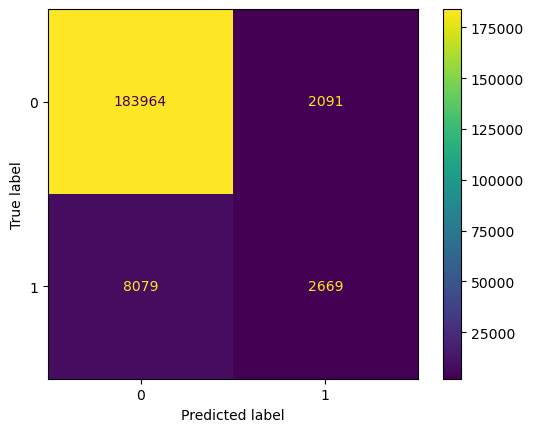

In [147]:
# Confusion Matrix (table + plot)
cm_blrpipe_train_V2 = confusion_matrix(y_train, y_train_blrpipe_pred_V2)
print(cm_blrpipe_train_V2)
ConfusionMatrixDisplay(confusion_matrix=cm_blrpipe_train_V2).plot();

V2 Test Metrics

In [148]:
# Classification Report (accuracy, precision, recall, f1)
report_blrpipe_test_V2 = classification_report(y_test, y_test_blrpipe_pred_V2)
print(report_blrpipe_test_V2)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     46514
         1.0       0.56      0.24      0.34      2687

    accuracy                           0.95     49201
   macro avg       0.76      0.62      0.66     49201
weighted avg       0.94      0.95      0.94     49201



[[45993   521]
 [ 2034   653]]


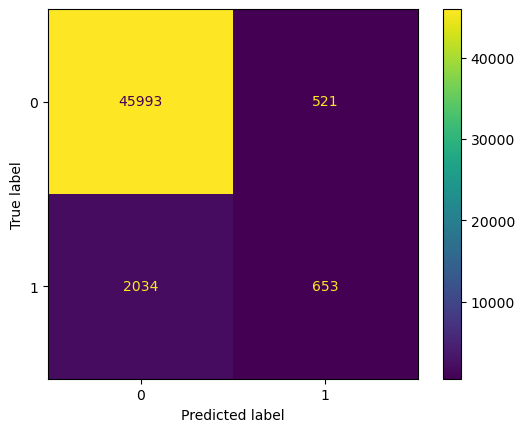

In [149]:
# Confusion Matrix (table + plot)
cm_blrpipe_test_V2 = confusion_matrix(y_test, y_test_blrpipe_pred_V2)
print(cm_blrpipe_test_V2)
ConfusionMatrixDisplay(confusion_matrix=cm_blrpipe_test_V2).plot();

                                  Coeff
AgeCategory_enc                0.614441
HadAngina_enc                  0.582689
Gender_enc                     0.357589
ChestScan_enc                  0.276937
SmokerStatus_enc               0.176950
HadStroke_enc                  0.173004
HadDiabetes_enc                0.115851
HIVTesting_enc                 0.038674
BlindOrVisionDifficulty_enc    0.029119
DifficultyWalking_enc          0.026444
DifficultyErrands_enc          0.024868
PneumoVaxEver_enc              0.023156
HadCOPD_enc                    0.018381
HadDepressiveDisorder_enc      0.015737
MentalHealthDays               0.013348
HadArthritis_enc               0.012042
HadAsthma_enc                  0.010328
HadKidneyDisease_enc           0.007851
ECigaretteUsage_enc            0.007572
DeafOrHardOfHearing_enc        0.006012
BMI                            0.005144
HighRiskLastYear_enc           0.003614
CovidPos_enc                   0.001597
WeightInKilograms              0.000000


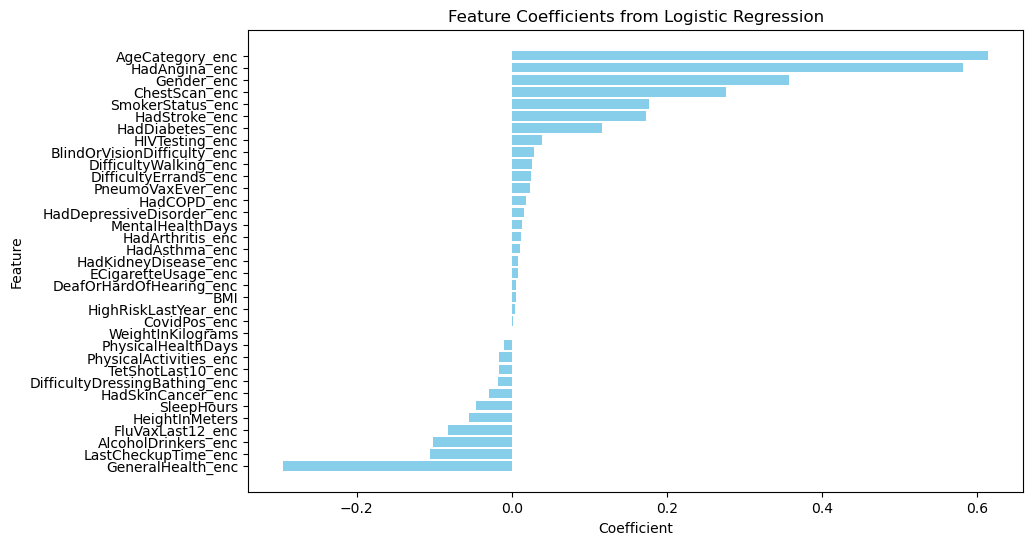

In [153]:
# Extract the logistic regression model from the pipeline
best_lr_logreg_model_V2 = best_lr_pipe_V2.named_steps['lr']

# Get the coefficients
coeff = best_lr_logreg_model_V2.coef_[0]

# Create a DataFrame for the coefficients
logreg_coeff4 = pd.DataFrame(coeff, index=X_train.columns, columns=['Coeff'])


# Sort the DataFrame by coefficient values
logreg_coeff4_sorted = logreg_coeff4.sort_values(by='Coeff', ascending=False)
print(logreg_coeff4_sorted)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(logreg_coeff4_sorted.index, logreg_coeff4_sorted['Coeff'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients from Logistic Regression')
plt.gca().invert_yaxis()  # To display the highest coefficients on top
plt.show()

#### Final Logistic Regression Model

In [ ]:
# Optimise with the best Parameters from the best logreg model

final_model = LogisticRegression(C=,random_state=)

# Remember that X_remainder and y_remainder held the data I split into train and validation
# I can use that data to re-train my model
final_model.fit(,)

final_model.score(X_test, y_test)

#### Model - Decision Tree

In [154]:
# Pre-processing - scale the data
scaler = StandardScaler()
scaler.fit(X_train)

# Transform the data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [6]:
#Instantiate
dt_model = DecisionTreeClassifier(random_state= 12, max_depth= 4)

# Fit Model
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=12)

In [7]:
# Make predictions
y_train_pred_dt = dt_model.predict(X_train)
y_val_pred_dt = dt_model.predict(X_val)
y_test_pred_dt = dt_model.predict(X_test)

In [8]:
# Decision Tree Train Score
train_accuracy = accuracy_score(y_train, y_train_pred_dt)
print(f"Train Accuracy: {train_accuracy}")

# Decision Tree Validation Score
val_accuracy = accuracy_score(y_val, y_val_pred_dt)
print(f"Validation Accuracy: {val_accuracy}")

# Decision Tree Test Score
test_accuracy = accuracy_score(y_test, y_test_pred_dt)
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.9479276230545266
Validation Accuracy: 0.9479688016056502
Test Accuracy: 0.9476433405825084


Train DT

In [9]:
# Train Classification Report
print(classification_report(y_train, y_train_pred_dt))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    186055
         1.0       0.57      0.18      0.28     10748

    accuracy                           0.95    196803
   macro avg       0.76      0.59      0.63    196803
weighted avg       0.93      0.95      0.94    196803



<Figure size 800x600 with 0 Axes>

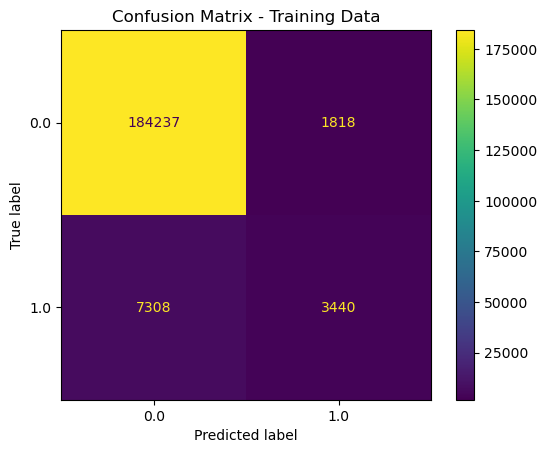

In [183]:
# Train Confusion Matrix
cm_dt_train = confusion_matrix(y_train, y_train_pred_dt)

# Display confusion matrix for training data
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_dt_train, display_labels=dt_model.classes_)
plt.figure(figsize=(8, 6))
disp_train.plot()
plt.title('Confusion Matrix - Training Data')
plt.show()

In [193]:
# Validation Classification Report
print(classification_report(y_val, y_val_pred_dt))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     37211
         1.0       0.64      0.32      0.42      2150

    accuracy                           0.95     39361
   macro avg       0.80      0.65      0.70     39361
weighted avg       0.94      0.95      0.95     39361



Validation DT

<Figure size 800x600 with 0 Axes>

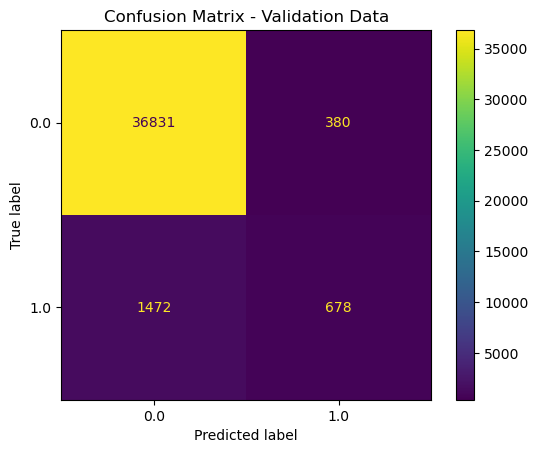

In [175]:
# Validation Confusion Matrix
cm_dt_val = confusion_matrix(y_val, y_val_pred_dt)

# Display confusion matrix for validation data
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_dt_val, display_labels=dt_model.classes_)
plt.figure(figsize=(8, 6))
disp_val.plot()
plt.title('Confusion Matrix - Validation Data')
plt.show()

Test DT

In [195]:
# Train Classification Report
print(classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     46514
         1.0       0.52      0.26      0.34      2687

    accuracy                           0.95     49201
   macro avg       0.74      0.62      0.66     49201
weighted avg       0.93      0.95      0.94     49201



<Figure size 800x600 with 0 Axes>

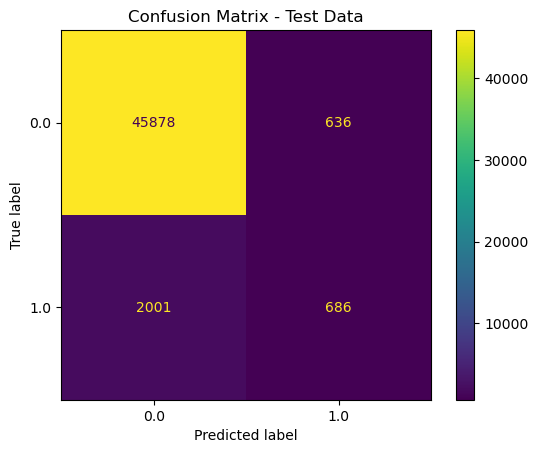

In [176]:
# Test Confusion Matrix
cm_dt_test = confusion_matrix(y_test, y_test_pred_dt)

# Display confusion matrix for test data
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_dt_test, display_labels=dt_model.classes_)
plt.figure(figsize=(8, 6))
disp_test.plot()
plt.title('Confusion Matrix - Test Data')
plt.show()

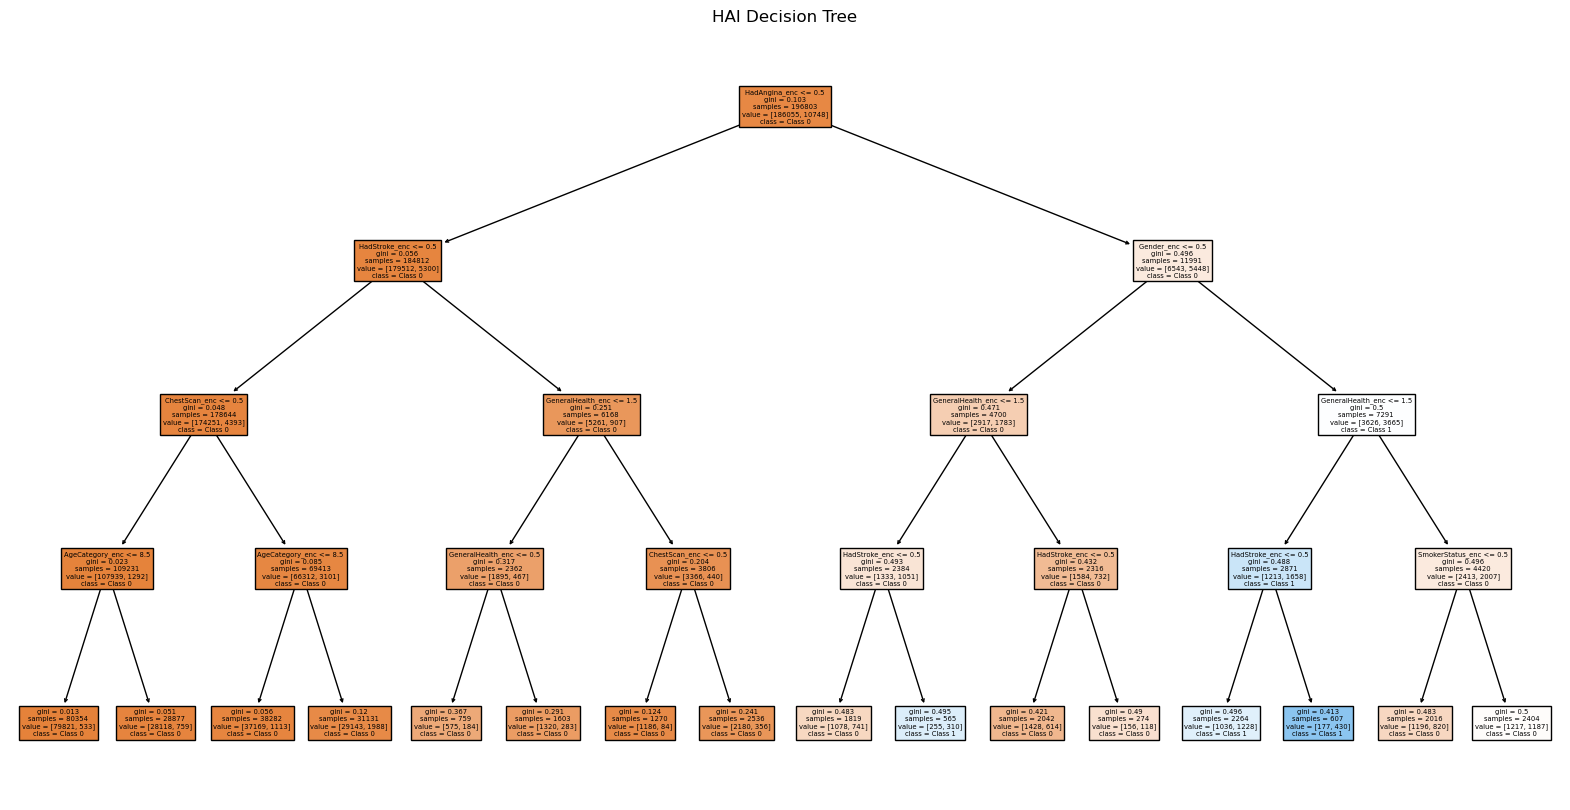

In [10]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, 
          filled=True, 
          feature_names=X_train.columns, 
          class_names=["No", "Yes"])
plt.title("HAI Decision Tree")
plt.show()

In [145]:
# Visualize Decision Tree Results
#PlotBoundaries(dt_model, X_train, y_train)

In [12]:
heart_attack_enc_m.groupby(by='GeneralHealth_enc').mean()[['HadHeartAttack_enc']]

HadHeartAttack_enc
GeneralHealth_enc                    
0.0                          0.214634
1.0                          0.122256
2.0                          0.059415
3.0                          0.028394
4.0                          0.014306

In [208]:
# Get feature importances
feature_importances = dt_model.feature_importances_

# Get feature names
feature_names = X_train.columns

dt_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

dt_feature_importance_df = dt_feature_importance_df.sort_values(by='Importance', ascending=False)
print(dt_feature_importance_df)

                          Feature  Importance
16                  HadAngina_enc    0.663870
17                  HadStroke_enc    0.038768
5                             BMI    0.036639
8               GeneralHealth_enc    0.033836
12                AgeCategory_enc    0.028405
4               WeightInKilograms    0.024997
7                      Gender_enc    0.019501
29                  ChestScan_enc    0.017640
3                  HeightInMeters    0.016616
10               SmokerStatus_enc    0.014503
2                      SleepHours    0.013456
0              PhysicalHealthDays    0.013128
1                MentalHealthDays    0.009981
14                HadDiabetes_enc    0.006401
30            AlcoholDrinkers_enc    0.006325
9          PhysicalActivities_enc    0.004982
26          DifficultyWalking_enc    0.004592
11            ECigaretteUsage_enc    0.003686
25    BlindOrVisionDifficulty_enc    0.003478
28          DifficultyErrands_enc    0.003405
22           HadKidneyDisease_enc 

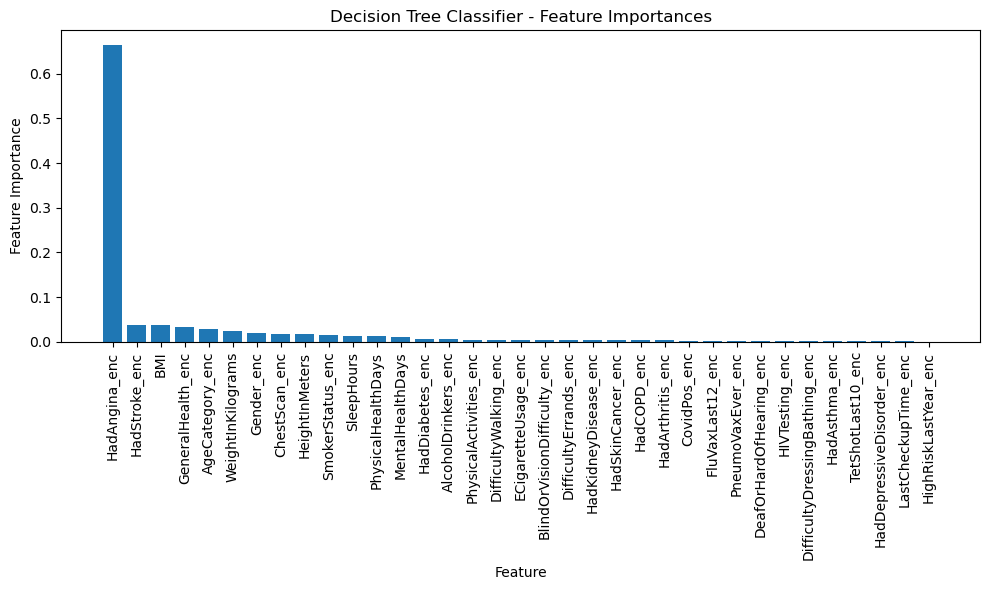

In [209]:
# Get feature importances
feature_importances = dt_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Decision Tree Classifier - Feature Importances')
plt.tight_layout()
plt.show()


#### Model - Random Forest

Grid Search - Random Forest

In [69]:
# Making a pipeline esimator list 
PCA_rf_estimators = [('scaler', StandardScaler()),
                    ('rf', RandomForestClassifier(random_state=12))
]

pipe = Pipeline(PCA_rf_estimators)
print(pipe) # Checking the pipe has been correctly made

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=12))])


In [70]:
# Defining rf V1 grid search

n_estimators = [5, 10, 20]
max_depth = [1, 2, 3, 4]
# min_samples_split = [2, 5]
# min_samples_leaf = [5, 10]
#max_features = ['sqrt', 'log2']

params = dict(
    rf = [RandomForestClassifier()],
    rf__n_estimators = n_estimators,
    rf__max_depth = max_depth,
    # rf__min_samples_split = min_samples_split,
    # rf__min_samples_leaf = min_samples_leaf,
    #rf__max_features = max_features
)
display(params)

{'rf': [RandomForestClassifier()],
 'rf__n_estimators': [5, 10, 20],
 'rf__max_depth': [1, 2, 3, 4]}

In [71]:
grid_search_model_rf_V1 = GridSearchCV(estimator= pipe, param_grid=params, cv=5, n_jobs= 4, verbose= 2)
grid_search_model_rf_V1.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=5; total time=   0.2s
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=5; total time=   0.2s
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=5; total time=   0.2s
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=5; total time=   0.2s
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=5; total time=   0.2s
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=10; total time=   0.3s
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=10; total time=   0.3s
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=10; total time=   0.3s
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=10; total time=   0.3s
[CV] END rf=RandomForestClassifier(), rf__max_depth=1, rf__n_estimators=10; total time=  

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=12))]),
             n_jobs=4,
             param_grid={'rf': [RandomForestClassifier(max_depth=4,
                                                       n_estimators=5)],
                         'rf__max_depth': [1, 2, 3, 4],
                         'rf__n_estimators': [5, 10, 20]},
             verbose=2)

In [72]:
# Extracting the essential information 

# Result of the grid search optimisation process - best hyperparameter and best model
print('Best Score:', grid_search_model_rf_V1.best_score_); 
print('Best Max Depth:', grid_search_model_rf_V1.best_estimator_.get_params()['rf__max_depth'])
print('Best Max Features:', grid_search_model_rf_V1.best_estimator_.get_params()['rf__max_features'])
print('Best Min Samples Leaf:', grid_search_model_rf_V1.best_estimator_.get_params()['rf__min_samples_leaf'])
#print('Best Min Samples Split:', grid_search_model_rf_V1.best_estimator_.get_params()['rf__min_samples_split'])
print('Best n estimators:', grid_search_model_rf_V1.best_estimator_.get_params()['rf__n_estimators'])

Best Score: 0.9455343683432261
Best Max Depth: 4
Best Max Features: auto
Best Min Samples Leaf: 1
Best n estimators: 5


In [73]:
best_rf1_model = grid_search_model_rf_V1.best_estimator_
print("Best parameters found: ", grid_search_model_rf_V1.best_params_)

Best parameters found:  {'rf': RandomForestClassifier(max_depth=4, n_estimators=5), 'rf__max_depth': 4, 'rf__n_estimators': 5}


In [74]:
y_train_pred_rf = best_rf1_model.predict(X_train)
y_val_pred_rf = best_rf1_model.predict(X_val)
y_test_pred_rf = best_rf1_model.predict(X_test)

In [75]:
# Best Random Forest component within the pipeline
best_rf_model_1 = best_rf1_model.named_steps['rf']

# Extract the individual trees from the best Random Forest model
individual_trees = best_rf_model_1.estimators_

# Print the number of trees
print(f"Number of trees in the best random forest model: {len(individual_trees)}")


Number of trees in the best random forest model: 5


In [76]:
print(individual_trees)

[DecisionTreeClassifier(max_depth=4, max_features='auto',
                       random_state=1808033550), DecisionTreeClassifier(max_depth=4, max_features='auto', random_state=13053665), DecisionTreeClassifier(max_depth=4, max_features='auto',
                       random_state=1410365026), DecisionTreeClassifier(max_depth=4, max_features='auto',
                       random_state=1134805784), DecisionTreeClassifier(max_depth=4, max_features='auto',
                       random_state=1512914623)]


In [77]:
train_rf_acc = accuracy_score(y_train, y_train_pred_rf)
print(train_rf_acc)

0.9453819301535038


In [78]:
# Print classification report for training data
print("Classification Report - Training Data:")
print(classification_report(y_train, y_train_pred_rf, zero_division=0))

# Print classification report for validation data
print("\nClassification Report - Validation Data:")
print(classification_report(y_val, y_val_pred_rf, zero_division=0))

# Print classification report for test data
print("\nClassification Report - Test Data:")
print(classification_report(y_test, y_test_pred_rf, zero_division=0))


Classification Report - Training Data:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97    186055
         1.0       0.00      0.00      0.00     10748

    accuracy                           0.95    196803
   macro avg       0.47      0.50      0.49    196803
weighted avg       0.89      0.95      0.92    196803


Classification Report - Validation Data:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     37211
         1.0       0.00      0.00      0.00      2150

    accuracy                           0.95     39361
   macro avg       0.47      0.50      0.49     39361
weighted avg       0.89      0.95      0.92     39361


Classification Report - Test Data:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46514
         1.0       0.00      0.00      0.00      2687

    accuracy                           0.95     49201
   macro av

                          Feature  Importance
34           HighRiskLastYear_enc    0.000000
21      HadDepressiveDisorder_enc    0.000000
19              HadSkinCancer_enc    0.000000
15                   CovidPos_enc    0.000000
28          DifficultyErrands_enc    0.000000
13              TetShotLast10_enc    0.000000
31                 HIVTesting_enc    0.000000
11            ECigaretteUsage_enc    0.000000
6             LastCheckupTime_enc    0.000000
5                             BMI    0.000000
4               WeightInKilograms    0.000000
32               FluVaxLast12_enc    0.000000
24        DeafOrHardOfHearing_enc    0.000433
18                  HadAsthma_enc    0.000664
27  DifficultyDressingBathing_enc    0.000890
1                MentalHealthDays    0.000901
2                      SleepHours    0.001005
25    BlindOrVisionDifficulty_enc    0.001301
30            AlcoholDrinkers_enc    0.001448
9          PhysicalActivities_enc    0.003057
33              PneumoVaxEver_enc 

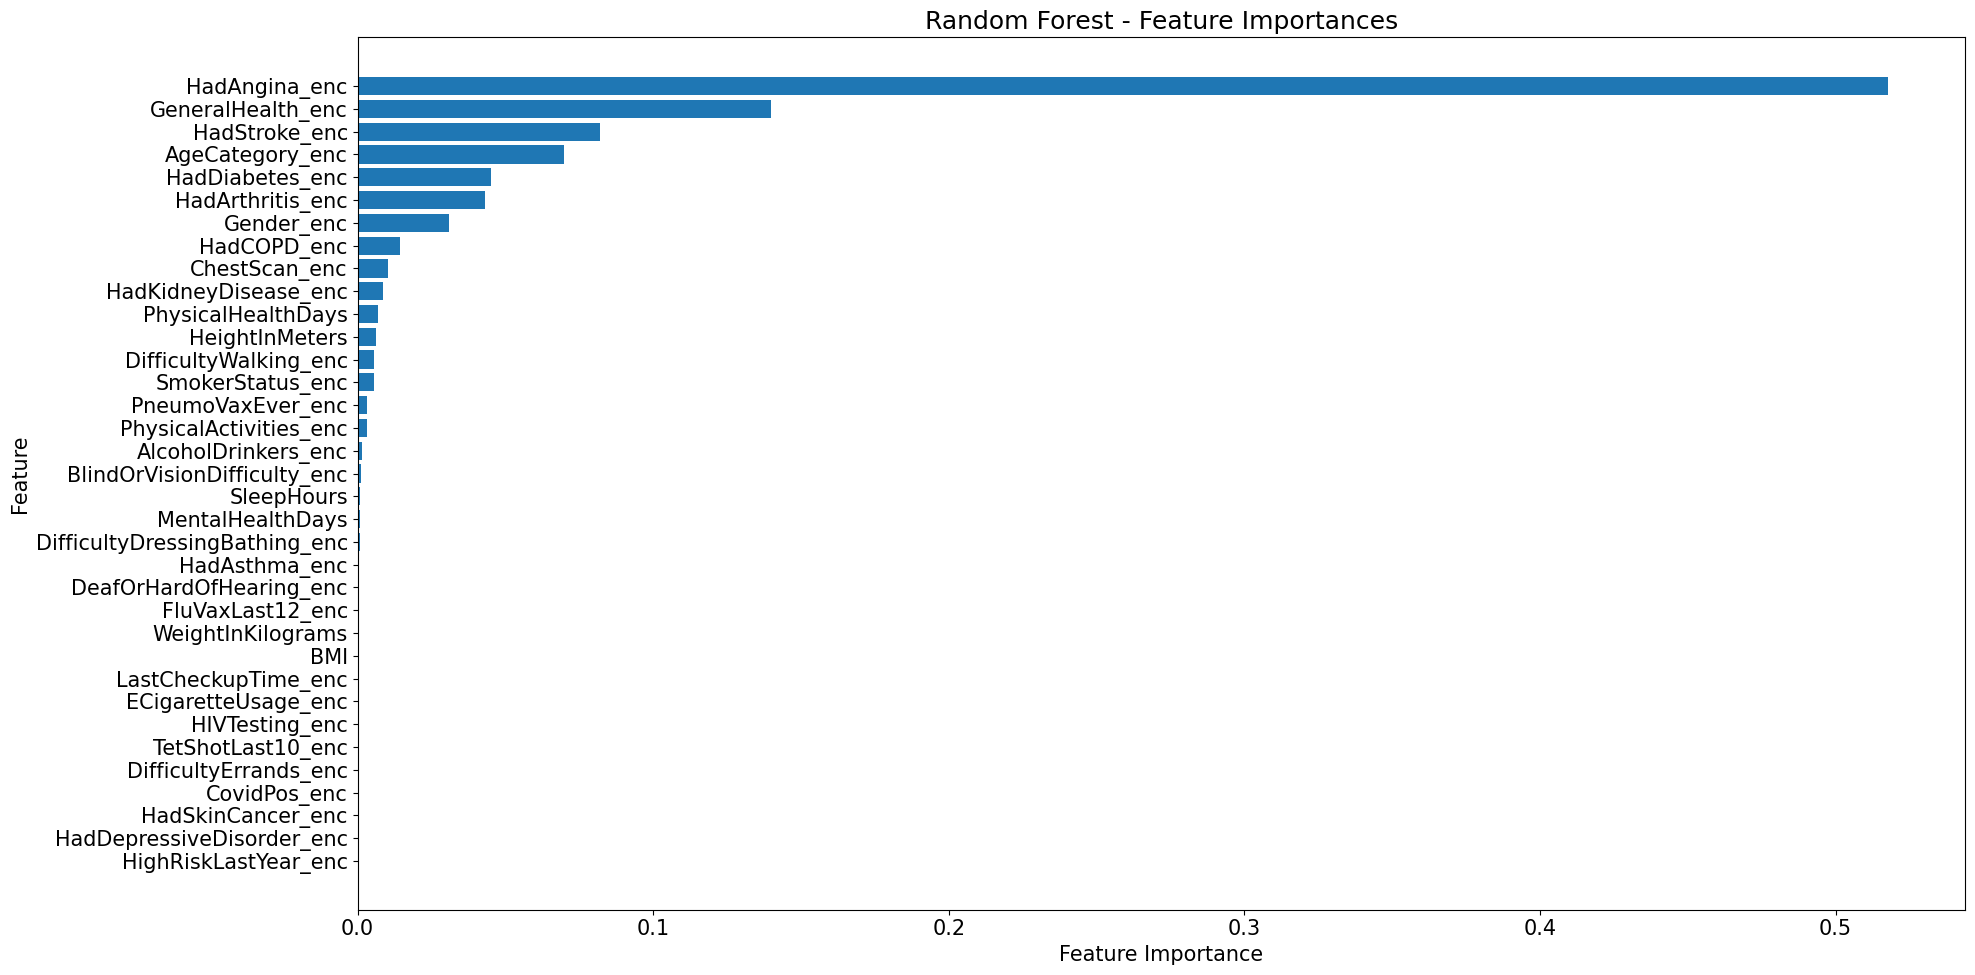

In [134]:
# Access the Random Forest component within the pipeline
best_rf01_model = best_rf1_model.named_steps['rf']

# Get feature importances
feature_importances = best_rf01_model.feature_importances_

# Get feature names
feature_names = X_train.columns  # Replace with your actual feature names

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the dataframe by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True, )

# Display the sorted dataframe
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(20, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest - Feature Importances')
plt.tight_layout()
plt.show()


**Best Random Forest - Decision Tree Visualizations**

Decision Tree Viz One

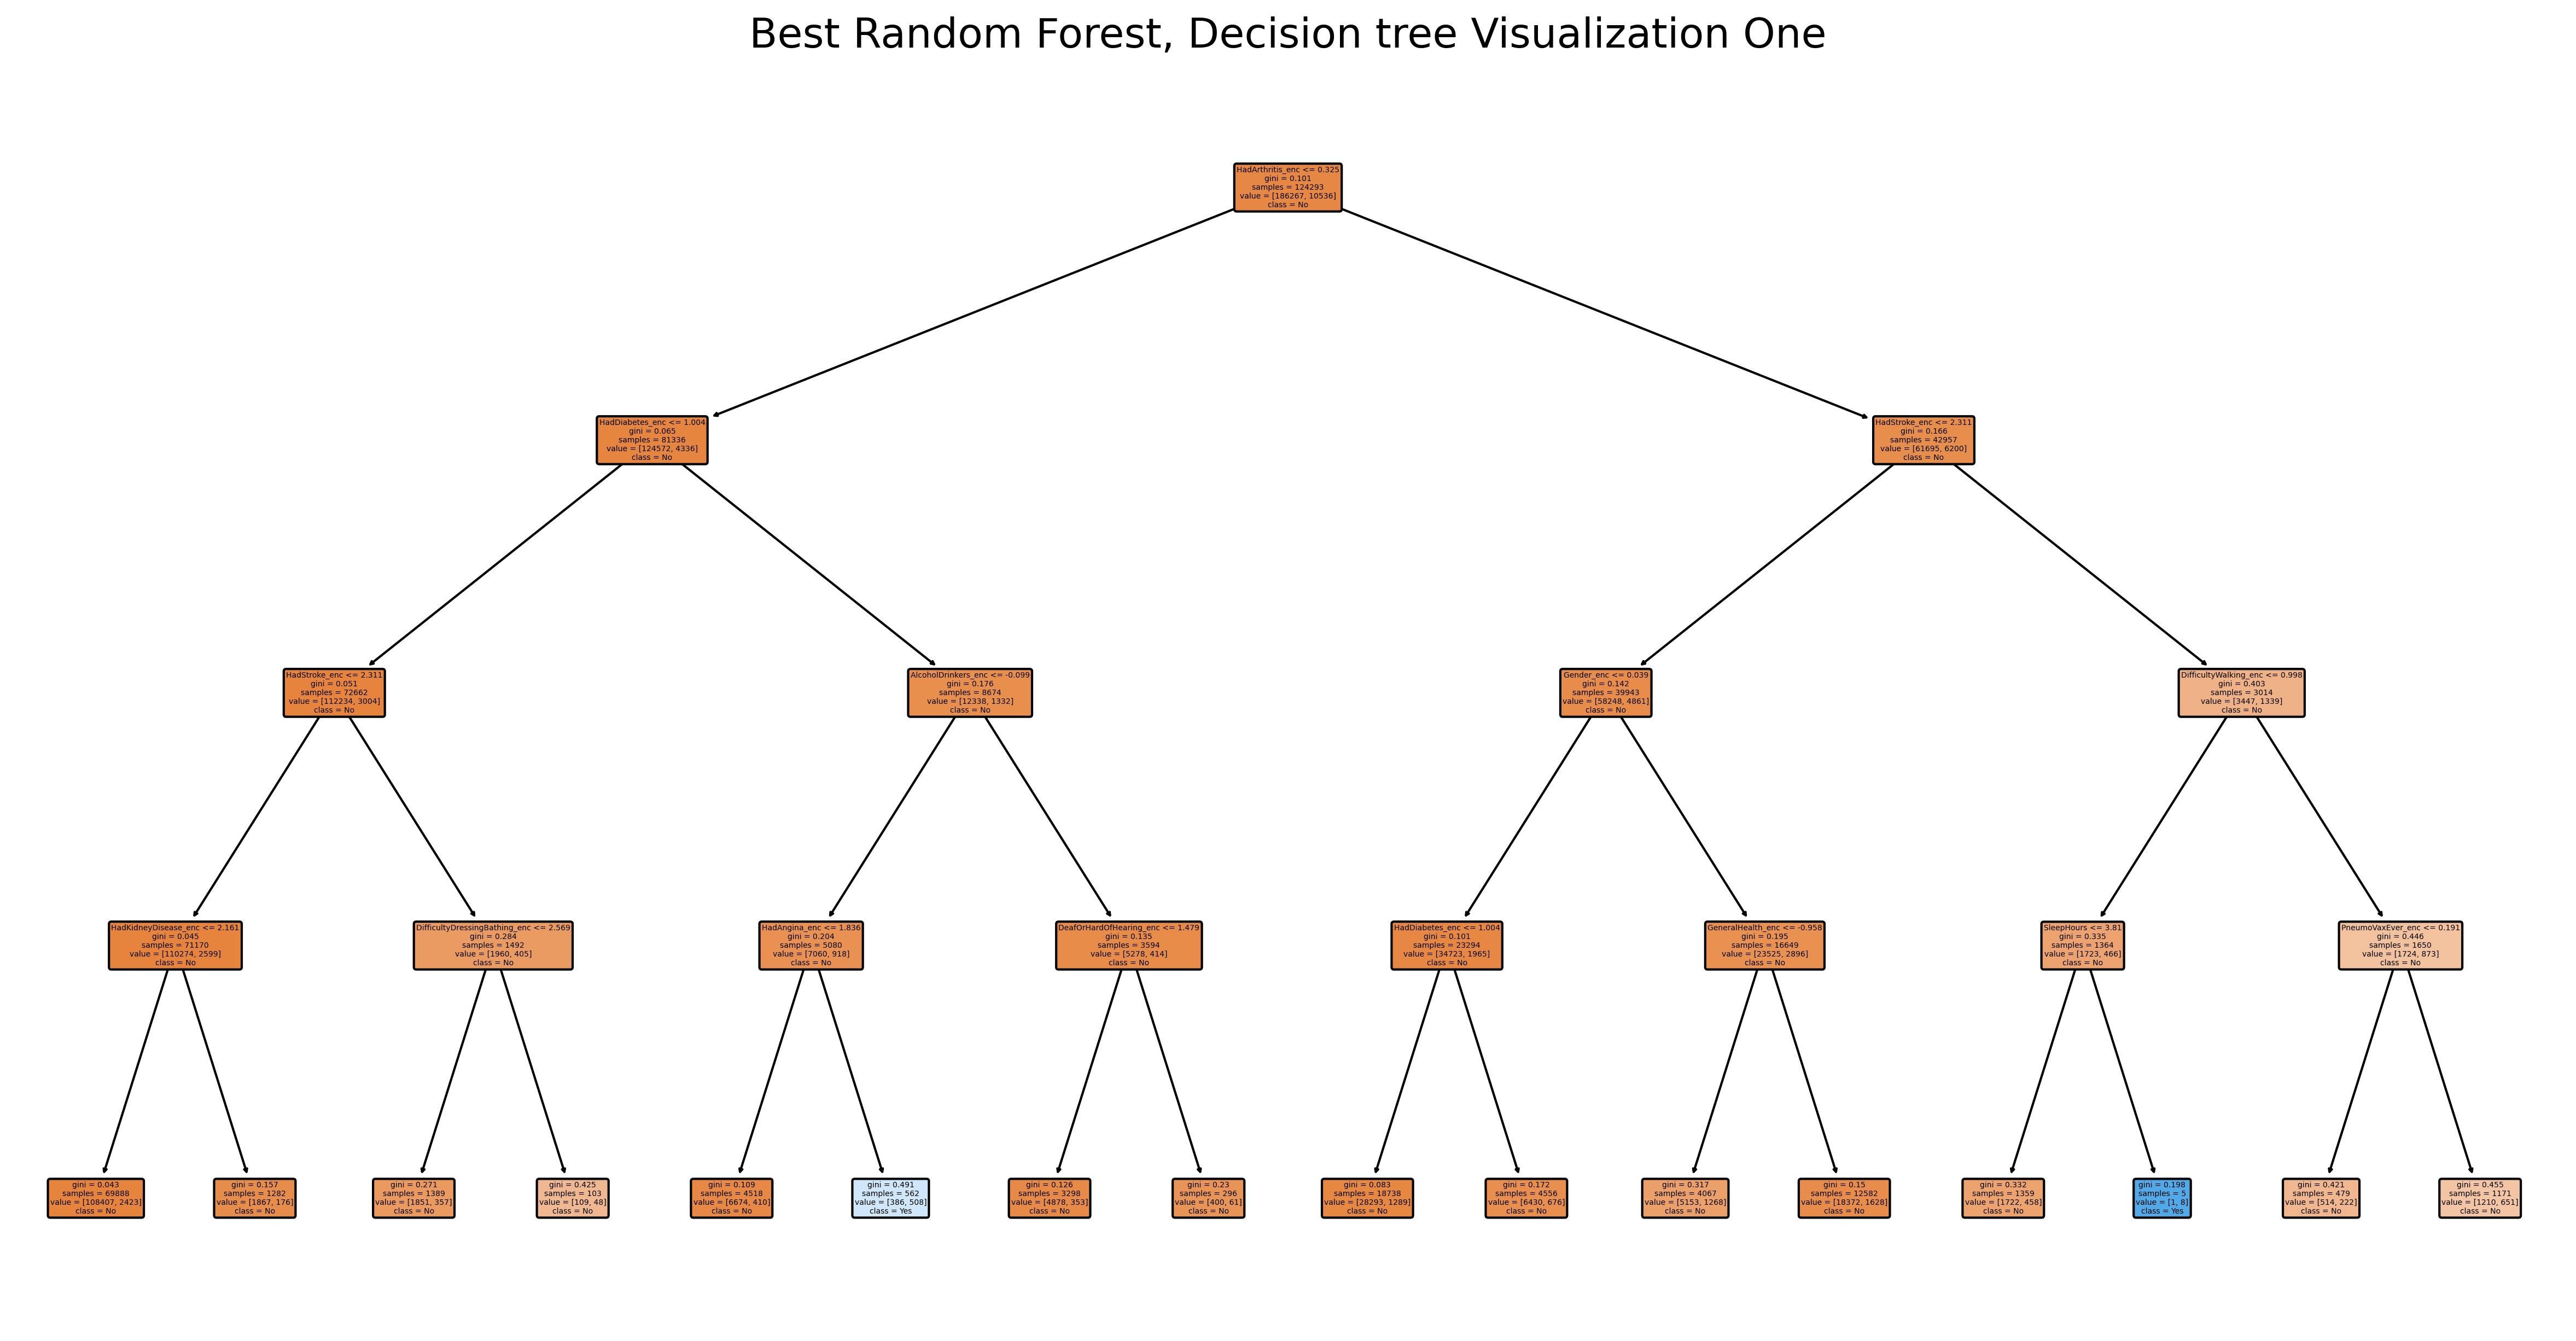

In [169]:
# Visualize dt One
plt.rcParams.update({'font.size': 15})

tree_idx = 0  # Index of the tree
plt.figure(figsize=(20, 10), dpi=300) # Size and dots per index, improves resolution
plot_tree(individual_trees[tree_idx],
          feature_names=X.columns,
          class_names= ["No", "Yes"],
          filled=True,
          rounded=True)
plt.title('Best Random Forest, Decision tree Visualization One')
plt.show()


Decision Tree Viz Two

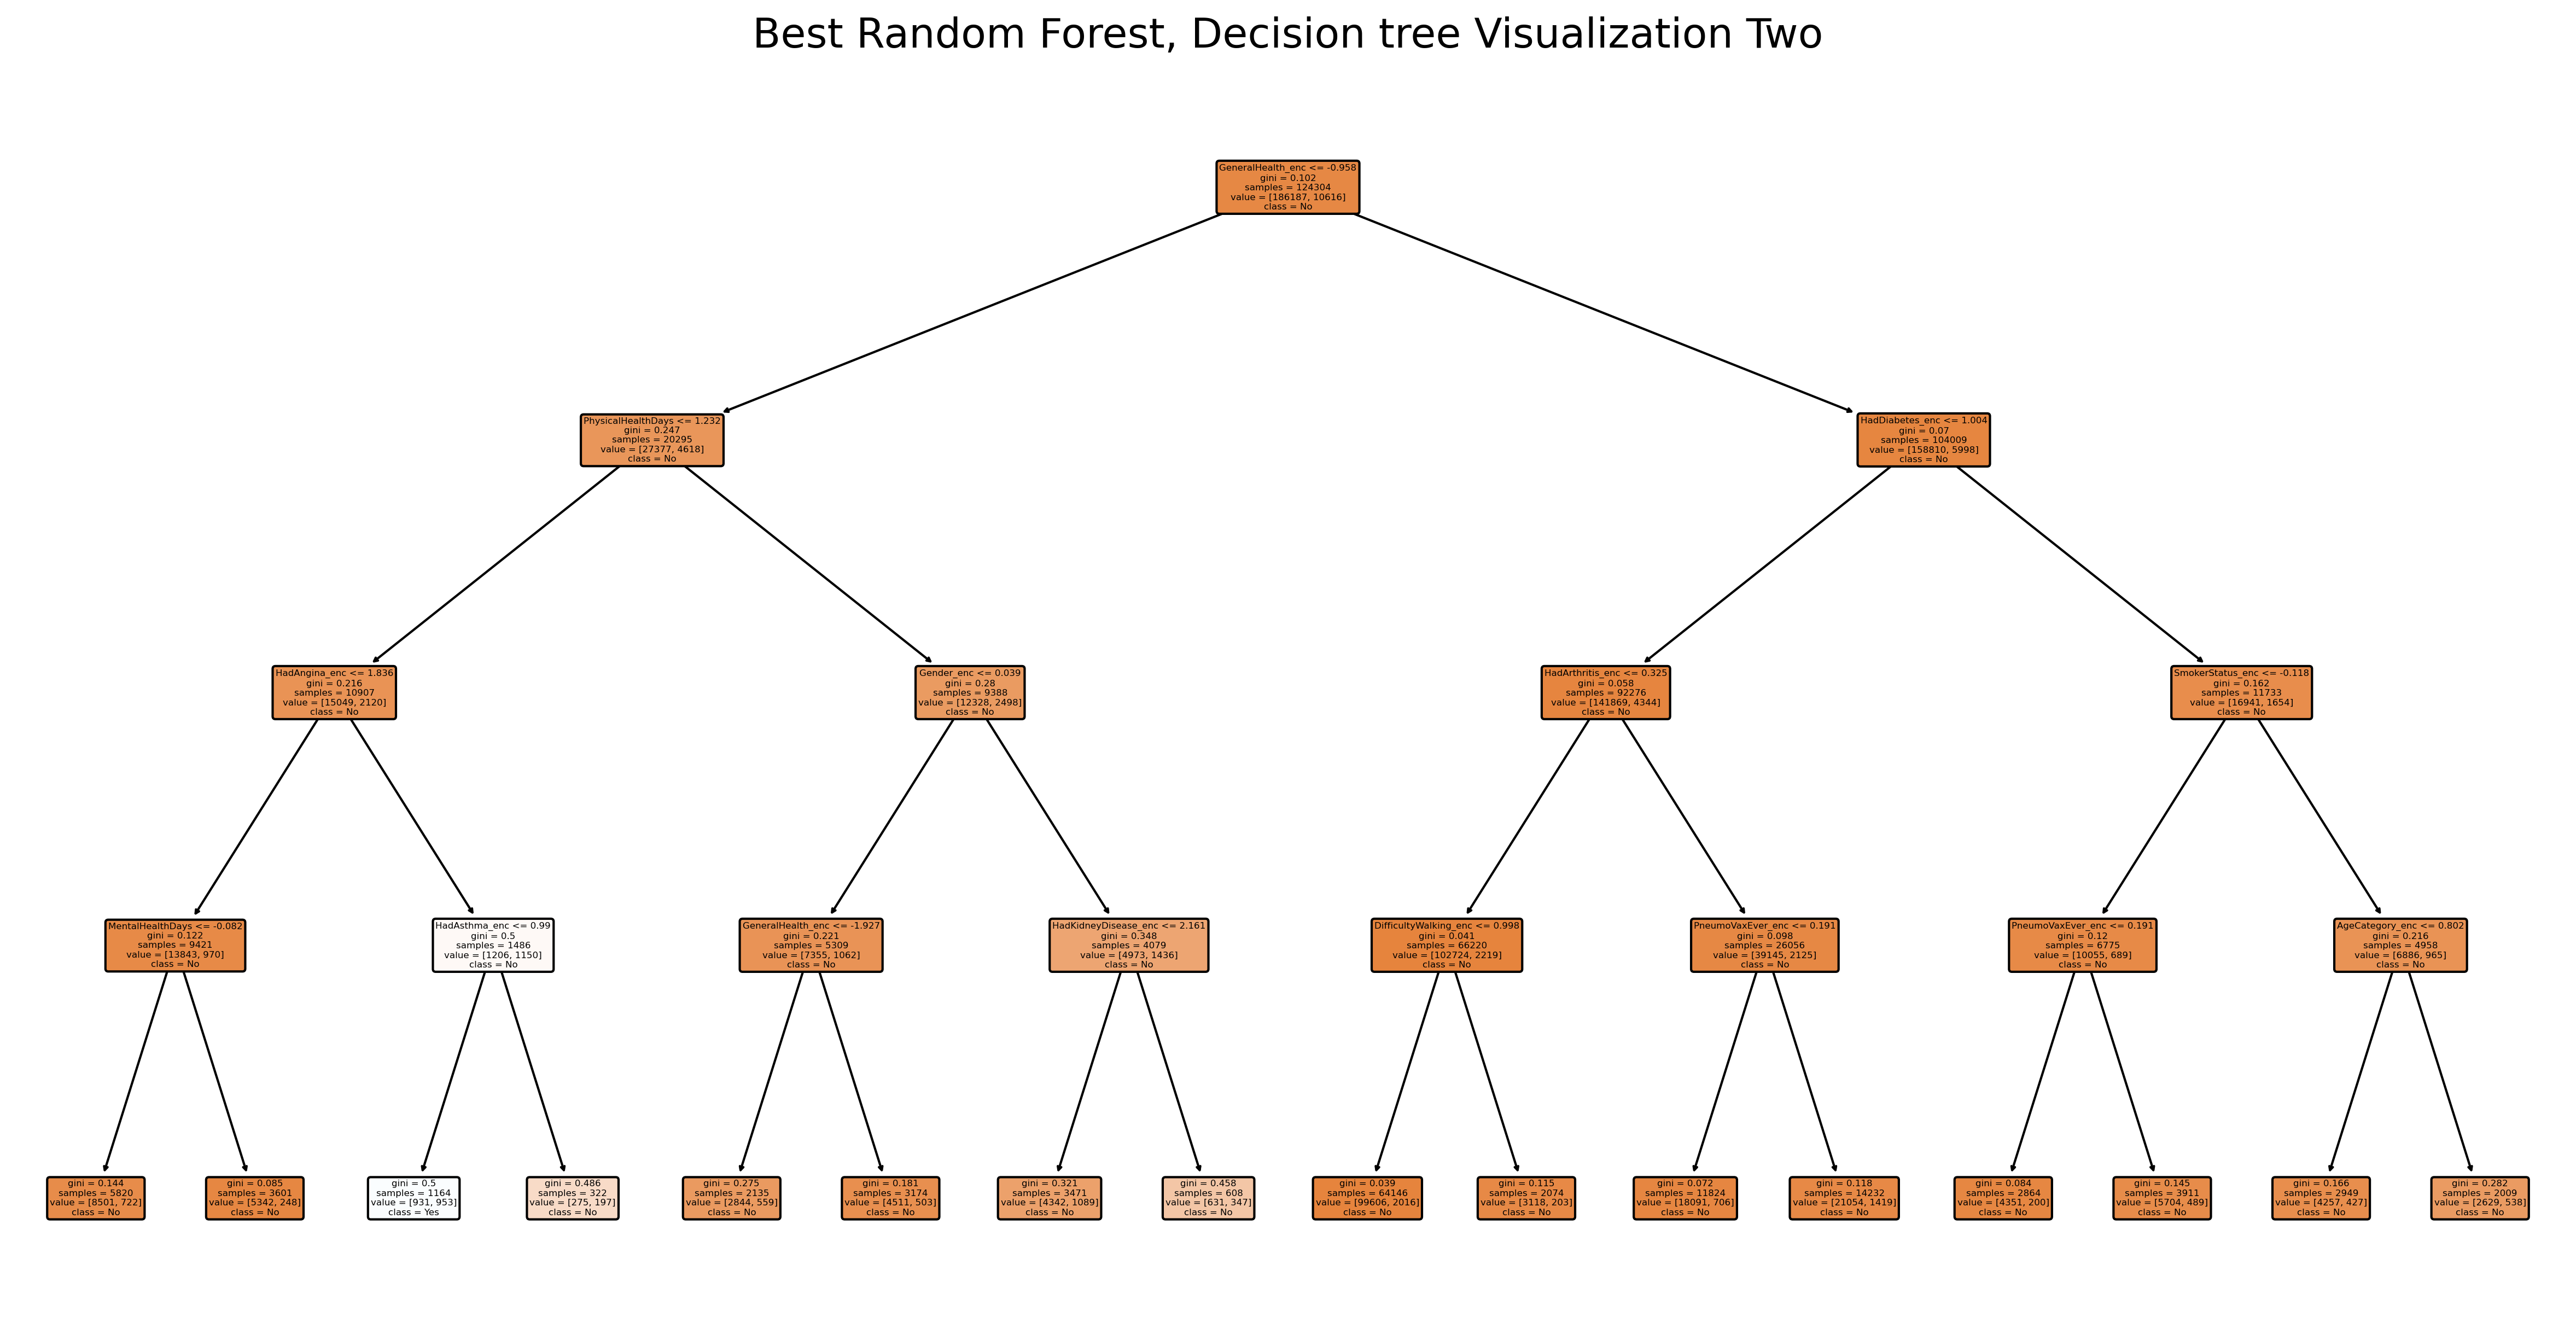

In [162]:
# Visualize dt Two
plt.rcParams.update({'font.size': 15})

tree_idx = 1  # Index of the tree
plt.figure(figsize=(20, 10), dpi=300) # Size and dots per index, improves resolution
plot_tree(individual_trees[tree_idx],
          feature_names=X.columns,
          class_names=["No", "Yes"],
          filled=True,
          rounded=True)
plt.title('Best Random Forest, Decision tree Visualization Two')
plt.show()

Decision Tree Viz Three

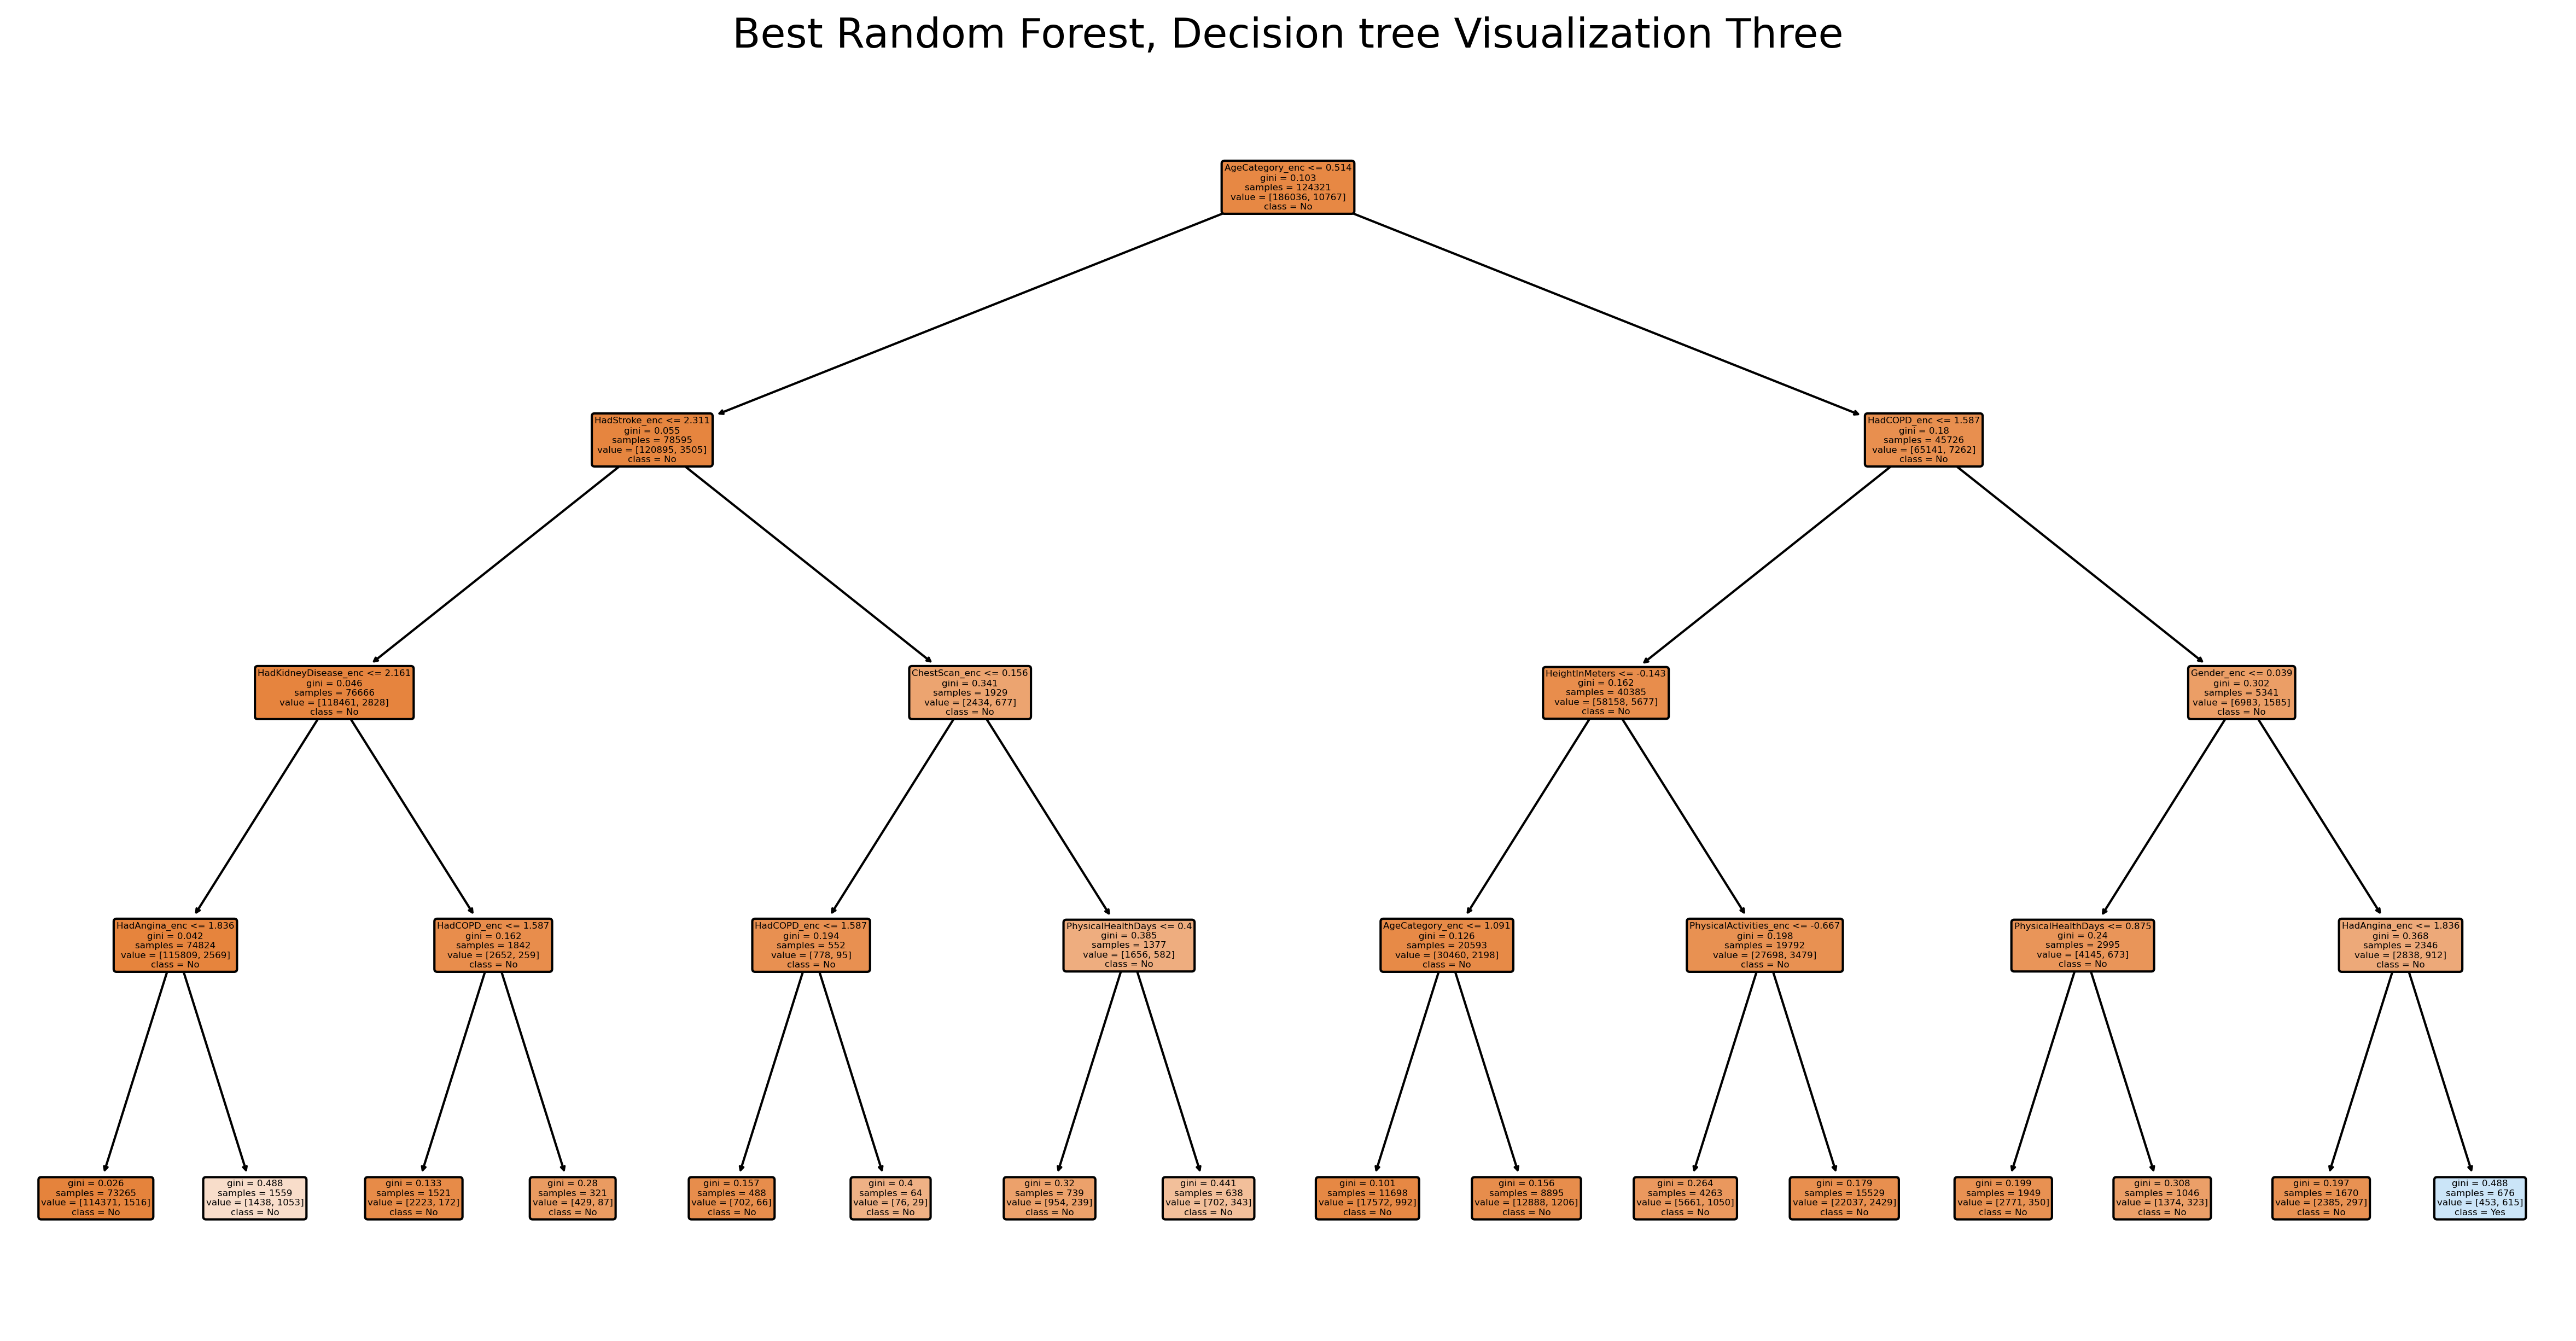

In [163]:
# Visualize dt Three
plt.rcParams.update({'font.size': 15})

tree_idx = 2  # Index of the tree
plt.figure(figsize=(20, 10), dpi=300) # Size and dots per index, improves resolution
plot_tree(individual_trees[tree_idx],
          feature_names=X.columns,
          class_names=["No", "Yes"],
          filled=True,
          rounded=True)
plt.title('Best Random Forest, Decision tree Visualization Three')
plt.show()

Decision Tree Viz Four

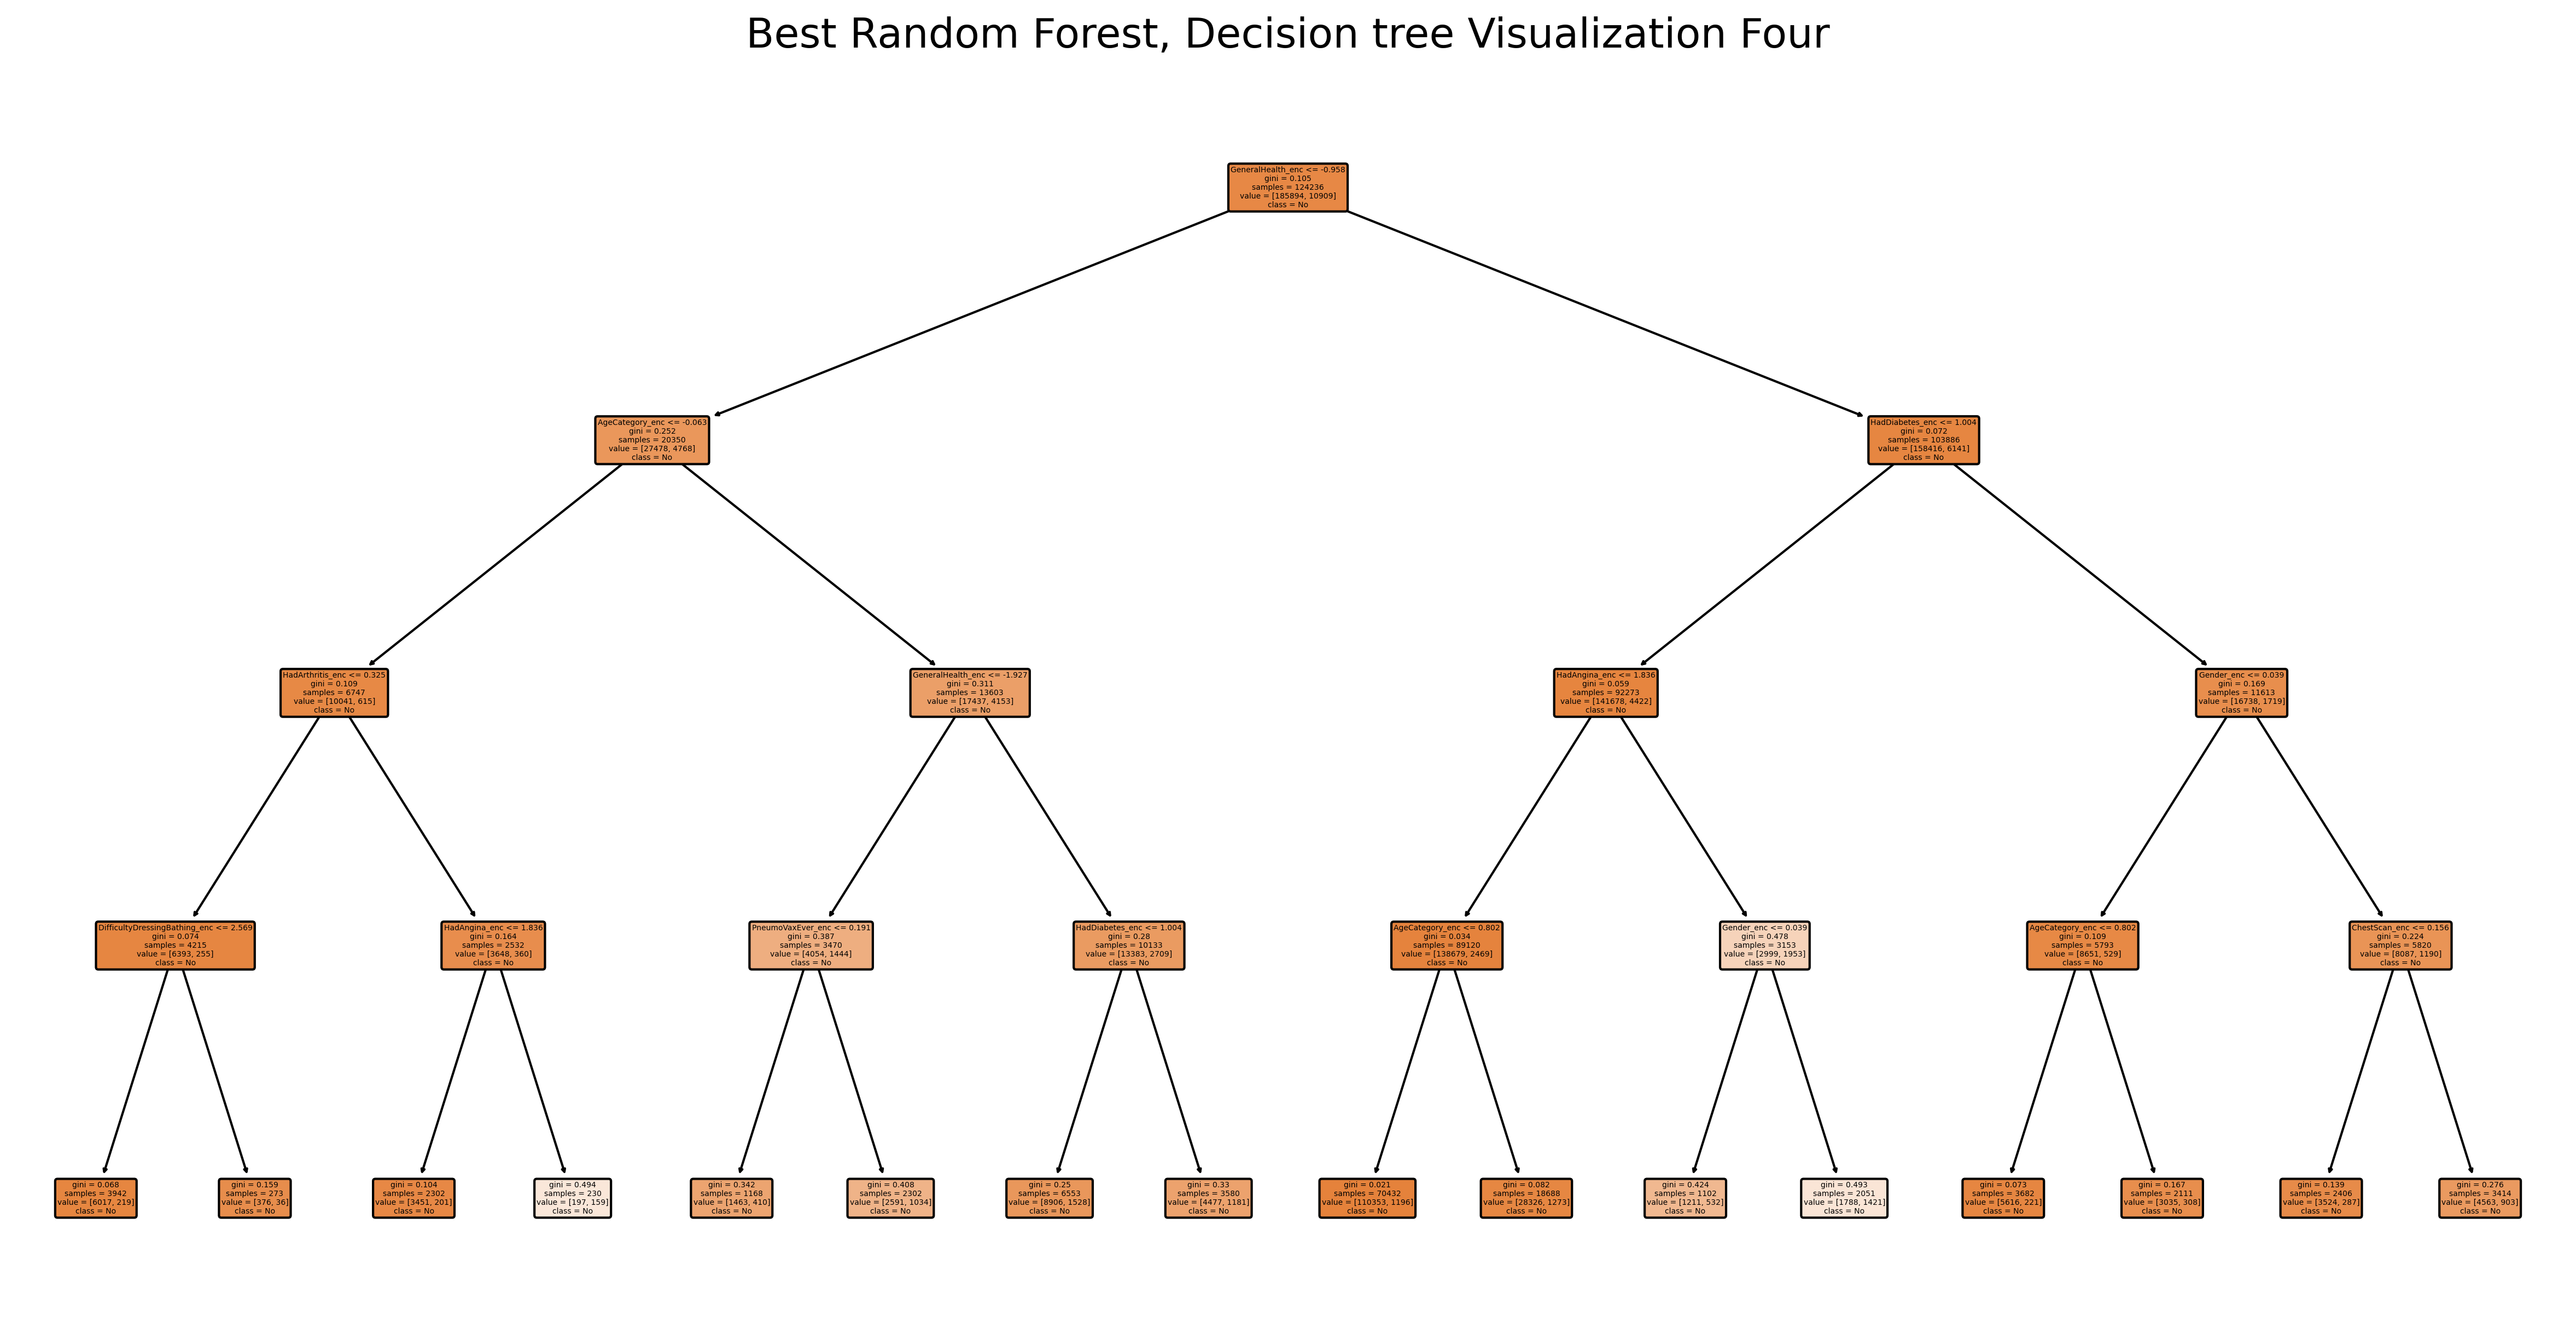

In [164]:
# Visualize dt Four
plt.rcParams.update({'font.size': 15})

tree_idx = 3  # Index of the tree
plt.figure(figsize=(20, 10), dpi=300) # Size and dots per index, improves resolution
plot_tree(individual_trees[tree_idx],
          feature_names=X.columns,
          class_names=["No", "Yes"],
          filled=True,
          rounded=True)
plt.title('Best Random Forest, Decision tree Visualization Four')
plt.show()

Decision Tree Viz Five

In [166]:
# Visualize dt Five

tree_idx = 4  # Index of the tree
plt.figure(figsize=(20, 10), dpi=300) # Size and dots per index, improves resolution
plot_tree(individual_trees[tree_idx],
          feature_names=X.columns,
          class_names=["No", "Yes"],
          filled=True,
          rounded=True)
plt.title('Best Random Forest, Decision tree Visualization Five')
plt.show()

KeyError: 'HadHeartAttack'

<Figure size 6000x3000 with 0 Axes>

#### Best Grid Search Model

#### KNN

In [ ]:
#del test_predictions1, test_accuracy1

In [140]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
# Instantiate the model & fit it to our data
KNN_model1 = KNeighborsClassifier(n_neighbors= 2)

KNN_model1.fit(X_train_scaled, y_train)

# Score the model on the test set
test_predictions1 = KNN_model1.predict(X_test)
test_accuracy1 = accuracy_score(test_predictions1, y_test)
print(f"Test set accuracy: {test_accuracy1}")

#PlotBoundaries(KNN_model1, X, y, plotsize=(10,7))

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Test set accuracy: 0.9453872888762423


In [143]:
y_train_pred_knn = KNN_model1.predict(X_train_scaled)
y_test_pred_knn = KNN_model1.predict(X_test_scaled)

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

In [144]:
# Generate and print the classification report for training data
print("Classification Report - Training Data")
print(classification_report(y_train, y_train_pred_knn))

# Generate and print the classification report for test data
print("Classification Report - Test Data")
print(classification_report(y_test, y_test_pred_knn))

Classification Report - Training Data
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    186055
         1.0       1.00      0.27      0.43     10748

    accuracy                           0.96    196803
   macro avg       0.98      0.64      0.70    196803
weighted avg       0.96      0.96      0.95    196803

Classification Report - Test Data
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     46514
         1.0       0.45      0.12      0.18      2687

    accuracy                           0.94     49201
   macro avg       0.70      0.55      0.58     49201
weighted avg       0.92      0.94      0.93     49201



#### XGBoost

In [150]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [151]:
xgb_model1 = XGBClassifier()
xgb_model1.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [152]:
y_train_pred_xgb = xgb_model1.predict(X_train_scaled)
y_test_pred_xgb = xgb_model1.predict(X_test_scaled)

In [153]:
# Generate and print the classification report for training data
print("Classification Report - Training Data")
print(classification_report(y_train, y_train_pred_xgb))

# Generate and print the classification report for test data
print("Classification Report - Test Data")
print(classification_report(y_test, y_test_pred_xgb))

Classification Report - Training Data
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    186055
         1.0       0.77      0.35      0.48     10748

    accuracy                           0.96    196803
   macro avg       0.87      0.67      0.73    196803
weighted avg       0.95      0.96      0.95    196803

Classification Report - Test Data
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     46514
         1.0       0.55      0.24      0.33      2687

    accuracy                           0.95     49201
   macro avg       0.75      0.61      0.65     49201
weighted avg       0.94      0.95      0.94     49201



Confusion Matrix - Training Data
[[184940   1115]
 [  7012   3736]]


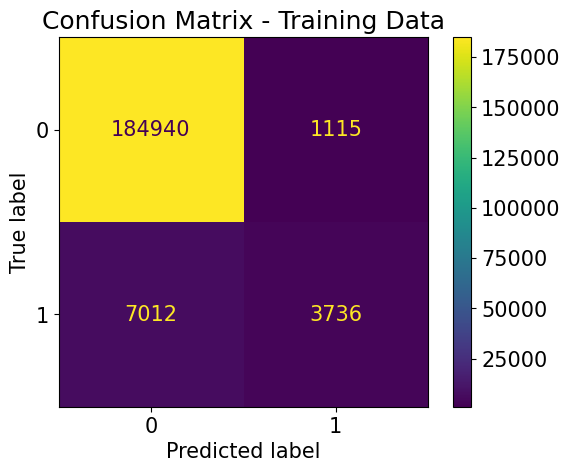

In [154]:
# Train Data Confusion Matrix
cm_train_xgb = confusion_matrix(y_train, y_train_pred_xgb)
print("Confusion Matrix - Training Data")
print(cm_train_xgb)
ConfusionMatrixDisplay(confusion_matrix=cm_train_xgb).plot()
plt.title("Confusion Matrix - Training Data")
plt.show()

Confusion Matrix - Test Data
[[45987   527]
 [ 2043   644]]


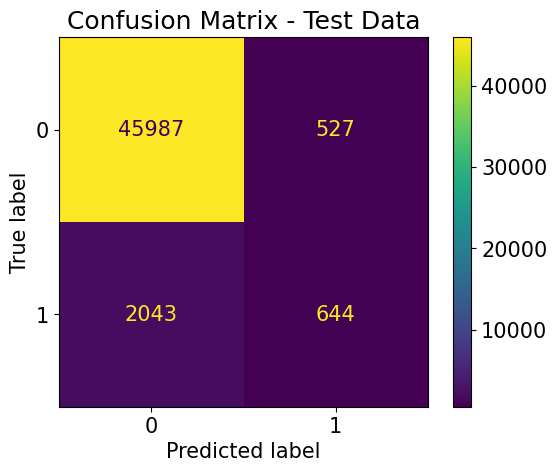

In [155]:
# Test Data Confusion Matrix
cm_test_xgb = confusion_matrix(y_test, y_test_pred_xgb)
print("Confusion Matrix - Test Data")
print(cm_test_xgb)
ConfusionMatrixDisplay(confusion_matrix=cm_test_xgb).plot()
plt.title("Confusion Matrix - Test Data")
plt.show()

                          Feature  Importance
16                  HadAngina_enc    0.539721
29                  ChestScan_enc    0.072506
17                  HadStroke_enc    0.054277
7                      Gender_enc    0.029847
12                AgeCategory_enc    0.028162
8               GeneralHealth_enc    0.026866
26          DifficultyWalking_enc    0.018835
14                HadDiabetes_enc    0.018649
10               SmokerStatus_enc    0.012852
30            AlcoholDrinkers_enc    0.011226
20                    HadCOPD_enc    0.010375
25    BlindOrVisionDifficulty_enc    0.009098
19              HadSkinCancer_enc    0.008226
28          DifficultyErrands_enc    0.008134
24        DeafOrHardOfHearing_enc    0.008007
22           HadKidneyDisease_enc    0.007850
18                  HadAsthma_enc    0.007832
23               HadArthritis_enc    0.007645
2                      SleepHours    0.007625
34           HighRiskLastYear_enc    0.007464
31                 HIVTesting_enc 

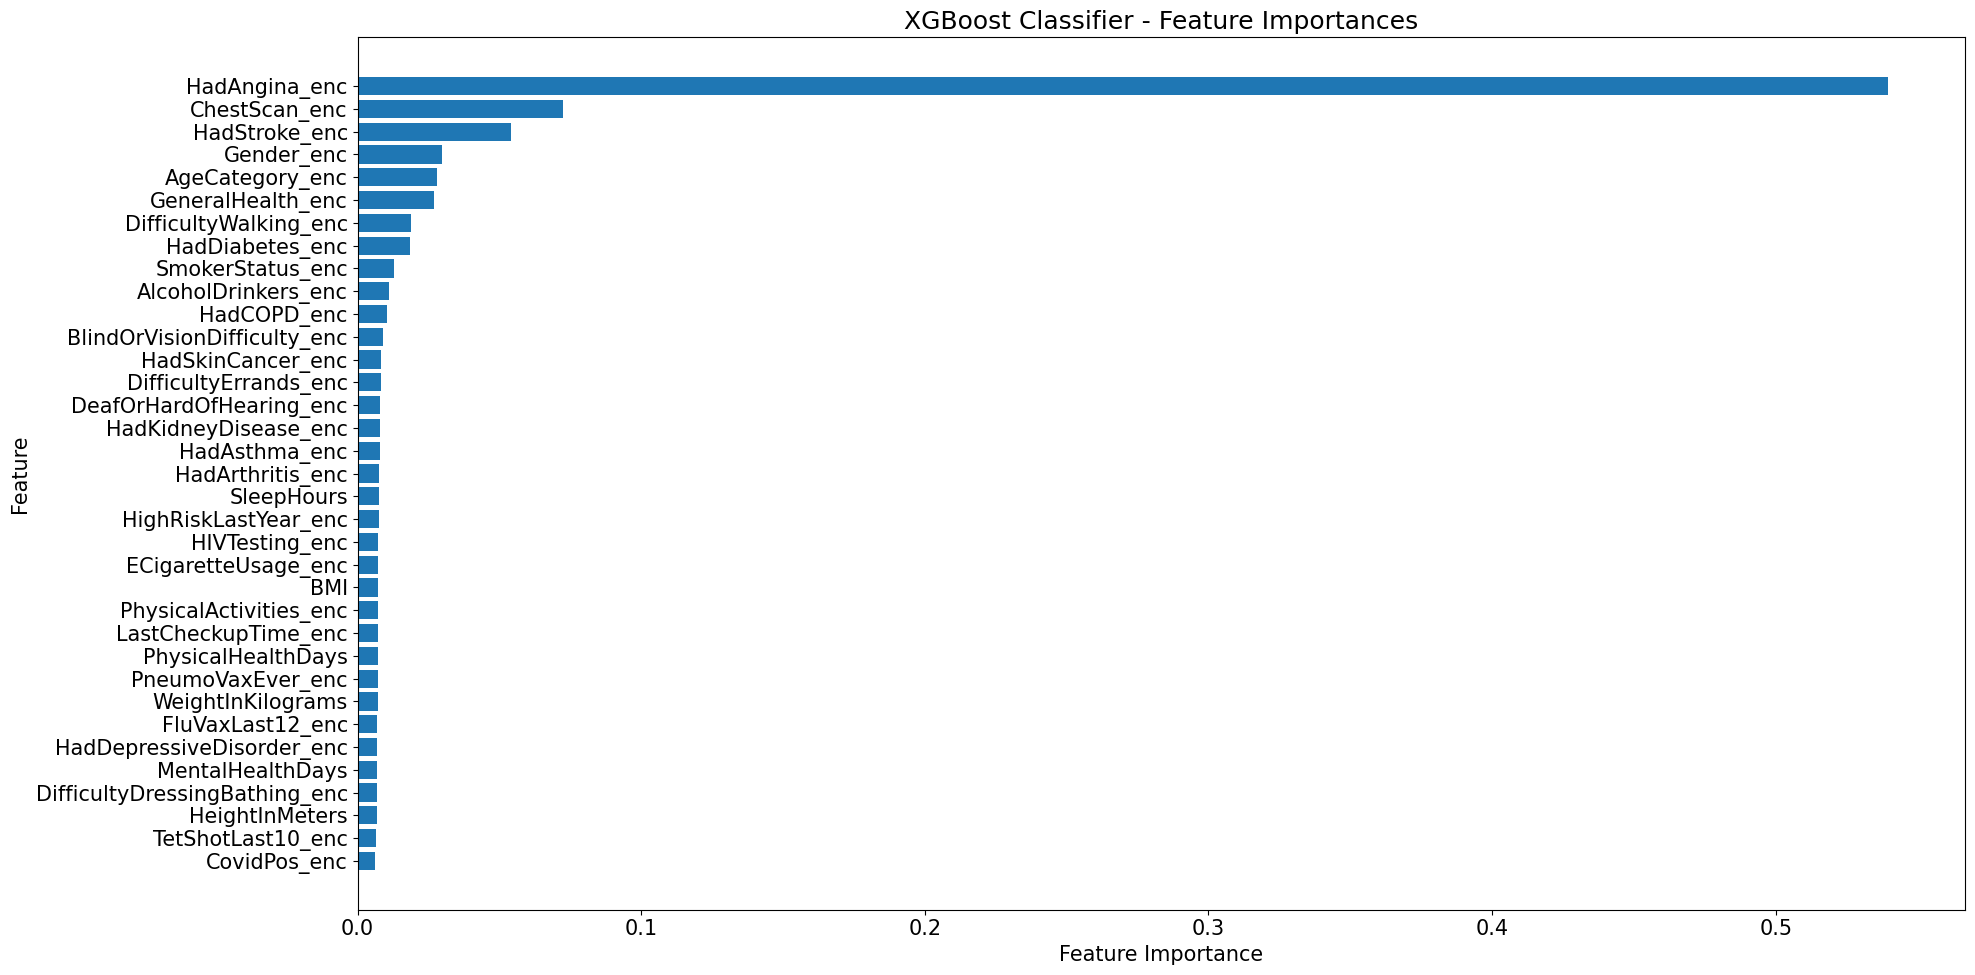

In [157]:
# Extract feature importances
feature_importances = xgb_model1.feature_importances_

# Get feature names
feature_names = X_train.columns  # Replace with your actual feature names

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(20, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('XGBoost Classifier - Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### SMOTENC